# Sciplex Dose

In [1]:
ood_seed = 13

In [2]:
num_ood = 1

In [3]:
obs_key = "condition"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('SAHA', '100.0'), 419)

Removed datapoint: 419


In [11]:
adata

AnnData object with n_obs × n_vars = 14392 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: ux8l39gm
Name: sith-force-468
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/ux8l39gm
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_095240-ux8l39gm/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1547,3569,2219,2481,1698
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 392,899,541,589,457
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:09<1:33:07,  9.33s/it]

Epoch 1/600:   0%|          | 1/600 [00:09<1:33:07,  9.33s/it, v_num=gm_1, total_loss_train=2.64e+3, kl_local_train=26.6]

Epoch 2/600:   0%|          | 1/600 [00:09<1:33:07,  9.33s/it, v_num=gm_1, total_loss_train=2.64e+3, kl_local_train=26.6]

Epoch 2/600:   0%|          | 2/600 [00:18<1:31:29,  9.18s/it, v_num=gm_1, total_loss_train=2.64e+3, kl_local_train=26.6]

Epoch 2/600:   0%|          | 2/600 [00:18<1:31:29,  9.18s/it, v_num=gm_1, total_loss_train=2.22e+3, kl_local_train=49.9]

Epoch 3/600:   0%|          | 2/600 [00:18<1:31:29,  9.18s/it, v_num=gm_1, total_loss_train=2.22e+3, kl_local_train=49.9]

Epoch 3/600:   0%|          | 3/600 [00:27<1:30:27,  9.09s/it, v_num=gm_1, total_loss_train=2.22e+3, kl_local_train=49.9]

Epoch 3/600:   0%|          | 3/600 [00:27<1:30:27,  9.09s/it, v_num=gm_1, total_loss_train=2.19e+3, kl_local_train=55.2]

Epoch 4/600:   0%|          | 3/600 [00:27<1:30:27,  9.09s/it, v_num=gm_1, total_loss_train=2.19e+3, kl_local_train=55.2]

Epoch 4/600:   1%|          | 4/600 [00:36<1:30:00,  9.06s/it, v_num=gm_1, total_loss_train=2.19e+3, kl_local_train=55.2]

Epoch 4/600:   1%|          | 4/600 [00:36<1:30:00,  9.06s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=57]  

Epoch 5/600:   1%|          | 4/600 [00:36<1:30:00,  9.06s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=57]

Epoch 5/600:   1%|          | 5/600 [00:45<1:31:27,  9.22s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=57]

Epoch 5/600:   1%|          | 5/600 [00:45<1:31:27,  9.22s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=56.1]

Epoch 6/600:   1%|          | 5/600 [00:46<1:31:27,  9.22s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=56.1]

Epoch 6/600:   1%|          | 6/600 [00:54<1:29:24,  9.03s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=56.1]

Epoch 6/600:   1%|          | 6/600 [00:54<1:29:24,  9.03s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 7/600:   1%|          | 6/600 [00:54<1:29:24,  9.03s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 7/600:   1%|          | 7/600 [01:02<1:26:37,  8.77s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 7/600:   1%|          | 7/600 [01:02<1:26:37,  8.77s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 8/600:   1%|          | 7/600 [01:02<1:26:37,  8.77s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 8/600:   1%|▏         | 8/600 [01:10<1:24:38,  8.58s/it, v_num=gm_1, total_loss_train=2.18e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 8/600:   1%|▏         | 8/600 [01:10<1:24:38,  8.58s/it, v_num=gm_1, total_loss_train=2.17e+3, kl_local_train=36, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]  

Epoch 9/600:   1%|▏         | 8/600 [01:10<1:24:38,  8.58s/it, v_num=gm_1, total_loss_train=2.17e+3, kl_local_train=36, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 9/600:   2%|▏         | 9/600 [01:19<1:23:10,  8.44s/it, v_num=gm_1, total_loss_train=2.17e+3, kl_local_train=36, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 9/600:   2%|▏         | 9/600 [01:19<1:23:10,  8.44s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 10/600:   2%|▏         | 9/600 [01:19<1:23:10,  8.44s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 10/600:   2%|▏         | 10/600 [01:27<1:23:04,  8.45s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 10/600:   2%|▏         | 10/600 [01:27<1:23:04,  8.45s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 11/600:   2%|▏         | 10/600 [01:28<1:23:04,  8.45s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 11/600:   2%|▏         | 11/600 [01:36<1:23:15,  8.48s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0396, metric_mi|condition_train=0.0297]

Epoch 11/600:   2%|▏         | 11/600 [01:36<1:23:15,  8.48s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119] 

Epoch 12/600:   2%|▏         | 11/600 [01:36<1:23:15,  8.48s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 12/600:   2%|▏         | 12/600 [01:44<1:22:05,  8.38s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 12/600:   2%|▏         | 12/600 [01:44<1:22:05,  8.38s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 13/600:   2%|▏         | 12/600 [01:44<1:22:05,  8.38s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 13/600:   2%|▏         | 13/600 [01:52<1:21:17,  8.31s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 13/600:   2%|▏         | 13/600 [01:52<1:21:17,  8.31s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 14/600:   2%|▏         | 13/600 [01:52<1:21:17,  8.31s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 14/600:   2%|▏         | 14/600 [02:00<1:20:40,  8.26s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 14/600:   2%|▏         | 14/600 [02:00<1:20:40,  8.26s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 15/600:   2%|▏         | 14/600 [02:00<1:20:40,  8.26s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 15/600:   2%|▎         | 15/600 [02:09<1:21:19,  8.34s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 15/600:   2%|▎         | 15/600 [02:09<1:21:19,  8.34s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 16/600:   2%|▎         | 15/600 [02:09<1:21:19,  8.34s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 16/600:   3%|▎         | 16/600 [02:17<1:21:52,  8.41s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0541, metric_mi|condition_train=0.119]

Epoch 16/600:   3%|▎         | 16/600 [02:17<1:21:52,  8.41s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 17/600:   3%|▎         | 16/600 [02:17<1:21:52,  8.41s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 17/600:   3%|▎         | 17/600 [02:25<1:20:53,  8.33s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 17/600:   3%|▎         | 17/600 [02:25<1:20:53,  8.33s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 18/600:   3%|▎         | 17/600 [02:25<1:20:53,  8.33s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 18/600:   3%|▎         | 18/600 [02:33<1:20:12,  8.27s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 18/600:   3%|▎         | 18/600 [02:33<1:20:12,  8.27s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 19/600:   3%|▎         | 18/600 [02:33<1:20:12,  8.27s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 19/600:   3%|▎         | 19/600 [02:42<1:19:37,  8.22s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 19/600:   3%|▎         | 19/600 [02:42<1:19:37,  8.22s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 20/600:   3%|▎         | 19/600 [02:42<1:19:37,  8.22s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 20/600:   3%|▎         | 20/600 [02:50<1:20:11,  8.29s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 20/600:   3%|▎         | 20/600 [02:50<1:20:11,  8.29s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=69, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]  

Epoch 21/600:   3%|▎         | 20/600 [02:50<1:20:11,  8.29s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=69, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 21/600:   4%|▎         | 21/600 [02:59<1:20:45,  8.37s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=69, metric_mi|dose_training_train=0.0609, metric_mi|condition_train=0.144]

Epoch 21/600:   4%|▎         | 21/600 [02:59<1:20:45,  8.37s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 22/600:   4%|▎         | 21/600 [02:59<1:20:45,  8.37s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 22/600:   4%|▎         | 22/600 [03:07<1:19:51,  8.29s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 22/600:   4%|▎         | 22/600 [03:07<1:19:51,  8.29s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 23/600:   4%|▎         | 22/600 [03:07<1:19:51,  8.29s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 23/600:   4%|▍         | 23/600 [03:15<1:19:09,  8.23s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 23/600:   4%|▍         | 23/600 [03:15<1:19:09,  8.23s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 24/600:   4%|▍         | 23/600 [03:15<1:19:09,  8.23s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 24/600:   4%|▍         | 24/600 [03:23<1:18:38,  8.19s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 24/600:   4%|▍         | 24/600 [03:23<1:18:38,  8.19s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 25/600:   4%|▍         | 24/600 [03:23<1:18:38,  8.19s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 25/600:   4%|▍         | 25/600 [03:31<1:19:11,  8.26s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 25/600:   4%|▍         | 25/600 [03:31<1:19:11,  8.26s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 26/600:   4%|▍         | 25/600 [03:32<1:19:11,  8.26s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 26/600:   4%|▍         | 26/600 [03:40<1:19:44,  8.34s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.125]

Epoch 26/600:   4%|▍         | 26/600 [03:40<1:19:44,  8.34s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12] 

Epoch 27/600:   4%|▍         | 26/600 [03:40<1:19:44,  8.34s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 27/600:   4%|▍         | 27/600 [03:48<1:18:49,  8.25s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 27/600:   4%|▍         | 27/600 [03:48<1:18:49,  8.25s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 28/600:   4%|▍         | 27/600 [03:48<1:18:49,  8.25s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 28/600:   5%|▍         | 28/600 [03:56<1:18:05,  8.19s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 28/600:   5%|▍         | 28/600 [03:56<1:18:05,  8.19s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 29/600:   5%|▍         | 28/600 [03:56<1:18:05,  8.19s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 29/600:   5%|▍         | 29/600 [04:04<1:17:33,  8.15s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 29/600:   5%|▍         | 29/600 [04:04<1:17:33,  8.15s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 30/600:   5%|▍         | 29/600 [04:04<1:17:33,  8.15s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 30/600:   5%|▌         | 30/600 [04:12<1:17:59,  8.21s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 30/600:   5%|▌         | 30/600 [04:12<1:17:59,  8.21s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 31/600:   5%|▌         | 30/600 [04:13<1:17:59,  8.21s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 31/600:   5%|▌         | 31/600 [04:21<1:18:50,  8.31s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0598, metric_mi|condition_train=0.12]

Epoch 31/600:   5%|▌         | 31/600 [04:21<1:18:50,  8.31s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 32/600:   5%|▌         | 31/600 [04:21<1:18:50,  8.31s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 32/600:   5%|▌         | 32/600 [04:29<1:18:00,  8.24s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 32/600:   5%|▌         | 32/600 [04:29<1:18:00,  8.24s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.9, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 33/600:   5%|▌         | 32/600 [04:29<1:18:00,  8.24s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.9, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 33/600:   6%|▌         | 33/600 [04:37<1:17:26,  8.19s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.9, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 33/600:   6%|▌         | 33/600 [04:37<1:17:26,  8.19s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 34/600:   6%|▌         | 33/600 [04:37<1:17:26,  8.19s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 34/600:   6%|▌         | 34/600 [04:45<1:17:12,  8.18s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 34/600:   6%|▌         | 34/600 [04:45<1:17:12,  8.18s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 35/600:   6%|▌         | 34/600 [04:45<1:17:12,  8.18s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 35/600:   6%|▌         | 35/600 [04:54<1:20:08,  8.51s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 35/600:   6%|▌         | 35/600 [04:54<1:20:08,  8.51s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 36/600:   6%|▌         | 35/600 [04:55<1:20:08,  8.51s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 36/600:   6%|▌         | 36/600 [05:03<1:20:16,  8.54s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.0624, metric_mi|condition_train=0.122]

Epoch 36/600:   6%|▌         | 36/600 [05:03<1:20:16,  8.54s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 37/600:   6%|▌         | 36/600 [05:03<1:20:16,  8.54s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 37/600:   6%|▌         | 37/600 [05:11<1:18:49,  8.40s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 37/600:   6%|▌         | 37/600 [05:11<1:18:49,  8.40s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 38/600:   6%|▌         | 37/600 [05:11<1:18:49,  8.40s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 38/600:   6%|▋         | 38/600 [05:19<1:17:46,  8.30s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 38/600:   6%|▋         | 38/600 [05:19<1:17:46,  8.30s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 39/600:   6%|▋         | 38/600 [05:19<1:17:46,  8.30s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 39/600:   6%|▋         | 39/600 [05:27<1:16:57,  8.23s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 39/600:   6%|▋         | 39/600 [05:27<1:16:57,  8.23s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 40/600:   6%|▋         | 39/600 [05:27<1:16:57,  8.23s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 40/600:   7%|▋         | 40/600 [05:36<1:18:21,  8.40s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 40/600:   7%|▋         | 40/600 [05:36<1:18:21,  8.40s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 41/600:   7%|▋         | 40/600 [05:36<1:18:21,  8.40s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 41/600:   7%|▋         | 41/600 [05:45<1:18:26,  8.42s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.132]

Epoch 41/600:   7%|▋         | 41/600 [05:45<1:18:26,  8.42s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 42/600:   7%|▋         | 41/600 [05:45<1:18:26,  8.42s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 42/600:   7%|▋         | 42/600 [05:53<1:17:17,  8.31s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 42/600:   7%|▋         | 42/600 [05:53<1:17:17,  8.31s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 43/600:   7%|▋         | 42/600 [05:53<1:17:17,  8.31s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 43/600:   7%|▋         | 43/600 [06:01<1:16:54,  8.28s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 43/600:   7%|▋         | 43/600 [06:01<1:16:54,  8.28s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 44/600:   7%|▋         | 43/600 [06:01<1:16:54,  8.28s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 44/600:   7%|▋         | 44/600 [06:09<1:16:12,  8.22s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 44/600:   7%|▋         | 44/600 [06:09<1:16:12,  8.22s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 45/600:   7%|▋         | 44/600 [06:09<1:16:12,  8.22s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 45/600:   8%|▊         | 45/600 [06:17<1:16:24,  8.26s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 45/600:   8%|▊         | 45/600 [06:17<1:16:24,  8.26s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 46/600:   8%|▊         | 45/600 [06:18<1:16:24,  8.26s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 46/600:   8%|▊         | 46/600 [06:26<1:16:49,  8.32s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 46/600:   8%|▊         | 46/600 [06:26<1:16:49,  8.32s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 47/600:   8%|▊         | 46/600 [06:26<1:16:49,  8.32s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 47/600:   8%|▊         | 47/600 [06:34<1:15:54,  8.24s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 47/600:   8%|▊         | 47/600 [06:34<1:15:54,  8.24s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 48/600:   8%|▊         | 47/600 [06:34<1:15:54,  8.24s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 48/600:   8%|▊         | 48/600 [06:42<1:15:08,  8.17s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 48/600:   8%|▊         | 48/600 [06:42<1:15:08,  8.17s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 49/600:   8%|▊         | 48/600 [06:42<1:15:08,  8.17s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 49/600:   8%|▊         | 49/600 [06:50<1:14:36,  8.12s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 49/600:   8%|▊         | 49/600 [06:50<1:14:36,  8.12s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 50/600:   8%|▊         | 49/600 [06:50<1:14:36,  8.12s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 50/600:   8%|▊         | 50/600 [06:58<1:15:22,  8.22s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 50/600:   8%|▊         | 50/600 [06:58<1:15:22,  8.22s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 51/600:   8%|▊         | 50/600 [06:59<1:15:22,  8.22s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 51/600:   8%|▊         | 51/600 [07:07<1:15:53,  8.29s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.136]

Epoch 51/600:   8%|▊         | 51/600 [07:07<1:15:53,  8.29s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 52/600:   8%|▊         | 51/600 [07:07<1:15:53,  8.29s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 52/600:   9%|▊         | 52/600 [07:15<1:14:57,  8.21s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 52/600:   9%|▊         | 52/600 [07:15<1:14:57,  8.21s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 53/600:   9%|▊         | 52/600 [07:15<1:14:57,  8.21s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 53/600:   9%|▉         | 53/600 [07:23<1:14:16,  8.15s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 53/600:   9%|▉         | 53/600 [07:23<1:14:16,  8.15s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 54/600:   9%|▉         | 53/600 [07:23<1:14:16,  8.15s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 54/600:   9%|▉         | 54/600 [07:31<1:13:45,  8.10s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 54/600:   9%|▉         | 54/600 [07:31<1:13:45,  8.10s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 55/600:   9%|▉         | 54/600 [07:31<1:13:45,  8.10s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 55/600:   9%|▉         | 55/600 [07:39<1:14:01,  8.15s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 55/600:   9%|▉         | 55/600 [07:39<1:14:01,  8.15s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 56/600:   9%|▉         | 55/600 [07:39<1:14:01,  8.15s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 56/600:   9%|▉         | 56/600 [07:47<1:14:42,  8.24s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.145]

Epoch 56/600:   9%|▉         | 56/600 [07:47<1:14:42,  8.24s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=77, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]  

Epoch 57/600:   9%|▉         | 56/600 [07:47<1:14:42,  8.24s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=77, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 57/600:  10%|▉         | 57/600 [07:55<1:13:54,  8.17s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=77, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 57/600:  10%|▉         | 57/600 [07:55<1:13:54,  8.17s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 58/600:  10%|▉         | 57/600 [07:55<1:13:54,  8.17s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 58/600:  10%|▉         | 58/600 [08:03<1:13:18,  8.12s/it, v_num=gm_1, total_loss_train=2.15e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 58/600:  10%|▉         | 58/600 [08:03<1:13:18,  8.12s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 59/600:  10%|▉         | 58/600 [08:03<1:13:18,  8.12s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 59/600:  10%|▉         | 59/600 [08:11<1:12:51,  8.08s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 59/600:  10%|▉         | 59/600 [08:11<1:12:51,  8.08s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 60/600:  10%|▉         | 59/600 [08:11<1:12:51,  8.08s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 60/600:  10%|█         | 60/600 [08:20<1:13:26,  8.16s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 60/600:  10%|█         | 60/600 [08:20<1:13:26,  8.16s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 61/600:  10%|█         | 60/600 [08:20<1:13:26,  8.16s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 61/600:  10%|█         | 61/600 [08:28<1:14:05,  8.25s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.158]

Epoch 61/600:  10%|█         | 61/600 [08:28<1:14:05,  8.25s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 62/600:  10%|█         | 61/600 [08:28<1:14:05,  8.25s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 62/600:  10%|█         | 62/600 [08:36<1:13:22,  8.18s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 62/600:  10%|█         | 62/600 [08:36<1:13:22,  8.18s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 63/600:  10%|█         | 62/600 [08:36<1:13:22,  8.18s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 63/600:  10%|█         | 63/600 [08:44<1:12:50,  8.14s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 63/600:  10%|█         | 63/600 [08:44<1:12:50,  8.14s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 64/600:  10%|█         | 63/600 [08:44<1:12:50,  8.14s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 64/600:  11%|█         | 64/600 [08:52<1:12:25,  8.11s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 64/600:  11%|█         | 64/600 [08:52<1:12:25,  8.11s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 65/600:  11%|█         | 64/600 [08:52<1:12:25,  8.11s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 65/600:  11%|█         | 65/600 [09:01<1:12:45,  8.16s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 65/600:  11%|█         | 65/600 [09:01<1:12:45,  8.16s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 66/600:  11%|█         | 65/600 [09:01<1:12:45,  8.16s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 66/600:  11%|█         | 66/600 [09:09<1:13:26,  8.25s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.169]

Epoch 66/600:  11%|█         | 66/600 [09:09<1:13:26,  8.25s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 67/600:  11%|█         | 66/600 [09:09<1:13:26,  8.25s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 67/600:  11%|█         | 67/600 [09:17<1:12:43,  8.19s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 67/600:  11%|█         | 67/600 [09:17<1:12:43,  8.19s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 68/600:  11%|█         | 67/600 [09:17<1:12:43,  8.19s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 68/600:  11%|█▏        | 68/600 [09:25<1:12:11,  8.14s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 68/600:  11%|█▏        | 68/600 [09:25<1:12:11,  8.14s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 69/600:  11%|█▏        | 68/600 [09:25<1:12:11,  8.14s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 69/600:  12%|█▏        | 69/600 [09:33<1:11:44,  8.11s/it, v_num=gm_1, total_loss_train=2.14e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 69/600:  12%|█▏        | 69/600 [09:33<1:11:44,  8.11s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 70/600:  12%|█▏        | 69/600 [09:33<1:11:44,  8.11s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 70/600:  12%|█▏        | 70/600 [09:42<1:12:38,  8.22s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 70/600:  12%|█▏        | 70/600 [09:42<1:12:38,  8.22s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 71/600:  12%|█▏        | 70/600 [09:42<1:12:38,  8.22s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 71/600:  12%|█▏        | 71/600 [09:50<1:13:08,  8.30s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 71/600:  12%|█▏        | 71/600 [09:50<1:13:08,  8.30s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=67, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]  

Epoch 72/600:  12%|█▏        | 71/600 [09:50<1:13:08,  8.30s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=67, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 72/600:  12%|█▏        | 72/600 [09:58<1:12:17,  8.22s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=67, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 72/600:  12%|█▏        | 72/600 [09:58<1:12:17,  8.22s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 73/600:  12%|█▏        | 72/600 [09:58<1:12:17,  8.22s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 73/600:  12%|█▏        | 73/600 [10:06<1:11:42,  8.16s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 73/600:  12%|█▏        | 73/600 [10:06<1:11:42,  8.16s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 74/600:  12%|█▏        | 73/600 [10:06<1:11:42,  8.16s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 74/600:  12%|█▏        | 74/600 [10:14<1:11:16,  8.13s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 74/600:  12%|█▏        | 74/600 [10:14<1:11:16,  8.13s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 75/600:  12%|█▏        | 74/600 [10:14<1:11:16,  8.13s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 75/600:  12%|█▎        | 75/600 [10:23<1:12:02,  8.23s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 75/600:  12%|█▎        | 75/600 [10:23<1:12:02,  8.23s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 76/600:  12%|█▎        | 75/600 [10:23<1:12:02,  8.23s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 76/600:  13%|█▎        | 76/600 [10:31<1:12:28,  8.30s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.185]

Epoch 76/600:  13%|█▎        | 76/600 [10:31<1:12:28,  8.30s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 77/600:  13%|█▎        | 76/600 [10:31<1:12:28,  8.30s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 77/600:  13%|█▎        | 77/600 [10:39<1:11:36,  8.22s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 77/600:  13%|█▎        | 77/600 [10:39<1:11:36,  8.22s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 78/600:  13%|█▎        | 77/600 [10:39<1:11:36,  8.22s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 78/600:  13%|█▎        | 78/600 [10:47<1:10:57,  8.16s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 78/600:  13%|█▎        | 78/600 [10:47<1:10:57,  8.16s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 79/600:  13%|█▎        | 78/600 [10:47<1:10:57,  8.16s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 79/600:  13%|█▎        | 79/600 [10:55<1:10:25,  8.11s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 79/600:  13%|█▎        | 79/600 [10:55<1:10:25,  8.11s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 80/600:  13%|█▎        | 79/600 [10:55<1:10:25,  8.11s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 80/600:  13%|█▎        | 80/600 [11:04<1:12:59,  8.42s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 80/600:  13%|█▎        | 80/600 [11:04<1:12:59,  8.42s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 81/600:  13%|█▎        | 80/600 [11:05<1:12:59,  8.42s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 81/600:  14%|█▎        | 81/600 [11:13<1:12:58,  8.44s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.187]

Epoch 81/600:  14%|█▎        | 81/600 [11:13<1:12:58,  8.44s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]  

Epoch 82/600:  14%|█▎        | 81/600 [11:13<1:12:58,  8.44s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 82/600:  14%|█▎        | 82/600 [11:21<1:11:48,  8.32s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=63, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 82/600:  14%|█▎        | 82/600 [11:21<1:11:48,  8.32s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 83/600:  14%|█▎        | 82/600 [11:21<1:11:48,  8.32s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 83/600:  14%|█▍        | 83/600 [11:29<1:10:55,  8.23s/it, v_num=gm_1, total_loss_train=2.13e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 83/600:  14%|█▍        | 83/600 [11:29<1:10:55,  8.23s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 84/600:  14%|█▍        | 83/600 [11:29<1:10:55,  8.23s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 84/600:  14%|█▍        | 84/600 [11:37<1:10:17,  8.17s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 84/600:  14%|█▍        | 84/600 [11:37<1:10:17,  8.17s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 85/600:  14%|█▍        | 84/600 [11:37<1:10:17,  8.17s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 85/600:  14%|█▍        | 85/600 [11:46<1:12:52,  8.49s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 85/600:  14%|█▍        | 85/600 [11:46<1:12:52,  8.49s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 86/600:  14%|█▍        | 85/600 [11:47<1:12:52,  8.49s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 86/600:  14%|█▍        | 86/600 [11:55<1:12:36,  8.48s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.186]

Epoch 86/600:  14%|█▍        | 86/600 [11:55<1:12:36,  8.48s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 87/600:  14%|█▍        | 86/600 [11:55<1:12:36,  8.48s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 87/600:  14%|█▍        | 87/600 [12:03<1:11:31,  8.37s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 87/600:  14%|█▍        | 87/600 [12:03<1:11:31,  8.37s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]  

Epoch 88/600:  14%|█▍        | 87/600 [12:03<1:11:31,  8.37s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 88/600:  15%|█▍        | 88/600 [12:11<1:10:41,  8.28s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 88/600:  15%|█▍        | 88/600 [12:11<1:10:41,  8.28s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 89/600:  15%|█▍        | 88/600 [12:11<1:10:41,  8.28s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 89/600:  15%|█▍        | 89/600 [12:19<1:10:04,  8.23s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 89/600:  15%|█▍        | 89/600 [12:19<1:10:04,  8.23s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 90/600:  15%|█▍        | 89/600 [12:19<1:10:04,  8.23s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 90/600:  15%|█▌        | 90/600 [12:28<1:12:40,  8.55s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 90/600:  15%|█▌        | 90/600 [12:28<1:12:40,  8.55s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 91/600:  15%|█▌        | 90/600 [12:29<1:12:40,  8.55s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 91/600:  15%|█▌        | 91/600 [12:37<1:12:27,  8.54s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.183]

Epoch 91/600:  15%|█▌        | 91/600 [12:37<1:12:27,  8.54s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 92/600:  15%|█▌        | 91/600 [12:37<1:12:27,  8.54s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 92/600:  15%|█▌        | 92/600 [12:45<1:10:36,  8.34s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 92/600:  15%|█▌        | 92/600 [12:45<1:10:36,  8.34s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 93/600:  15%|█▌        | 92/600 [12:45<1:10:36,  8.34s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 93/600:  16%|█▌        | 93/600 [12:52<1:09:15,  8.20s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 93/600:  16%|█▌        | 93/600 [12:52<1:09:15,  8.20s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 94/600:  16%|█▌        | 93/600 [12:52<1:09:15,  8.20s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 94/600:  16%|█▌        | 94/600 [13:00<1:08:18,  8.10s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 94/600:  16%|█▌        | 94/600 [13:00<1:08:18,  8.10s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 95/600:  16%|█▌        | 94/600 [13:00<1:08:18,  8.10s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 95/600:  16%|█▌        | 95/600 [13:09<1:10:33,  8.38s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 95/600:  16%|█▌        | 95/600 [13:09<1:10:33,  8.38s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 96/600:  16%|█▌        | 95/600 [13:10<1:10:33,  8.38s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 96/600:  16%|█▌        | 96/600 [13:18<1:10:44,  8.42s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 96/600:  16%|█▌        | 96/600 [13:18<1:10:44,  8.42s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 97/600:  16%|█▌        | 96/600 [13:18<1:10:44,  8.42s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 97/600:  16%|█▌        | 97/600 [13:26<1:09:40,  8.31s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 97/600:  16%|█▌        | 97/600 [13:26<1:09:40,  8.31s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 98/600:  16%|█▌        | 97/600 [13:26<1:09:40,  8.31s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 98/600:  16%|█▋        | 98/600 [13:34<1:08:55,  8.24s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 98/600:  16%|█▋        | 98/600 [13:34<1:08:55,  8.24s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 99/600:  16%|█▋        | 98/600 [13:34<1:08:55,  8.24s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 99/600:  16%|█▋        | 99/600 [13:42<1:08:20,  8.19s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 99/600:  16%|█▋        | 99/600 [13:42<1:08:20,  8.19s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 100/600:  16%|█▋        | 99/600 [13:42<1:08:20,  8.19s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 100/600:  17%|█▋        | 100/600 [13:51<1:10:50,  8.50s/it, v_num=gm_1, total_loss_train=2.12e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 100/600:  17%|█▋        | 100/600 [13:51<1:10:50,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 101/600:  17%|█▋        | 100/600 [13:52<1:10:50,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 101/600:  17%|█▋        | 101/600 [14:00<1:10:43,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.196]

Epoch 101/600:  17%|█▋        | 101/600 [14:00<1:10:43,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 102/600:  17%|█▋        | 101/600 [14:00<1:10:43,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 102/600:  17%|█▋        | 102/600 [14:08<1:09:28,  8.37s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 102/600:  17%|█▋        | 102/600 [14:08<1:09:28,  8.37s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 103/600:  17%|█▋        | 102/600 [14:08<1:09:28,  8.37s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 103/600:  17%|█▋        | 103/600 [14:16<1:08:38,  8.29s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 103/600:  17%|█▋        | 103/600 [14:16<1:08:38,  8.29s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=59, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]  

Epoch 104/600:  17%|█▋        | 103/600 [14:16<1:08:38,  8.29s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=59, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 104/600:  17%|█▋        | 104/600 [14:24<1:07:56,  8.22s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=59, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 104/600:  17%|█▋        | 104/600 [14:24<1:07:56,  8.22s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 105/600:  17%|█▋        | 104/600 [14:24<1:07:56,  8.22s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 105/600:  18%|█▊        | 105/600 [14:33<1:10:16,  8.52s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 105/600:  18%|█▊        | 105/600 [14:33<1:10:16,  8.52s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 106/600:  18%|█▊        | 105/600 [14:34<1:10:16,  8.52s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 106/600:  18%|█▊        | 106/600 [14:42<1:09:56,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.197]

Epoch 106/600:  18%|█▊        | 106/600 [14:42<1:09:56,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 107/600:  18%|█▊        | 106/600 [14:42<1:09:56,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 107/600:  18%|█▊        | 107/600 [14:50<1:08:36,  8.35s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 107/600:  18%|█▊        | 107/600 [14:50<1:08:36,  8.35s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 108/600:  18%|█▊        | 107/600 [14:50<1:08:36,  8.35s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 108/600:  18%|█▊        | 108/600 [14:58<1:07:37,  8.25s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 108/600:  18%|█▊        | 108/600 [14:58<1:07:37,  8.25s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 109/600:  18%|█▊        | 108/600 [14:58<1:07:37,  8.25s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 109/600:  18%|█▊        | 109/600 [15:06<1:07:03,  8.20s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 109/600:  18%|█▊        | 109/600 [15:06<1:07:03,  8.20s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 110/600:  18%|█▊        | 109/600 [15:06<1:07:03,  8.20s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 110/600:  18%|█▊        | 110/600 [15:15<1:09:34,  8.52s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 110/600:  18%|█▊        | 110/600 [15:15<1:09:34,  8.52s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 111/600:  18%|█▊        | 110/600 [15:15<1:09:34,  8.52s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 111/600:  18%|█▊        | 111/600 [15:23<1:09:17,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.197]

Epoch 111/600:  18%|█▊        | 111/600 [15:23<1:09:17,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]  

Epoch 112/600:  18%|█▊        | 111/600 [15:24<1:09:17,  8.50s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 112/600:  19%|█▊        | 112/600 [15:32<1:07:57,  8.36s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 112/600:  19%|█▊        | 112/600 [15:32<1:07:57,  8.36s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 113/600:  19%|█▊        | 112/600 [15:32<1:07:57,  8.36s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 113/600:  19%|█▉        | 113/600 [15:40<1:06:59,  8.25s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 113/600:  19%|█▉        | 113/600 [15:40<1:06:59,  8.25s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 114/600:  19%|█▉        | 113/600 [15:40<1:06:59,  8.25s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 114/600:  19%|█▉        | 114/600 [15:48<1:06:16,  8.18s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 114/600:  19%|█▉        | 114/600 [15:48<1:06:16,  8.18s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 115/600:  19%|█▉        | 114/600 [15:48<1:06:16,  8.18s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 115/600:  19%|█▉        | 115/600 [15:56<1:06:19,  8.21s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 115/600:  19%|█▉        | 115/600 [15:56<1:06:19,  8.21s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 116/600:  19%|█▉        | 115/600 [15:56<1:06:19,  8.21s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 116/600:  19%|█▉        | 116/600 [16:04<1:06:55,  8.30s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 116/600:  19%|█▉        | 116/600 [16:04<1:06:55,  8.30s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 117/600:  19%|█▉        | 116/600 [16:04<1:06:55,  8.30s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 117/600:  20%|█▉        | 117/600 [16:12<1:06:03,  8.21s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 117/600:  20%|█▉        | 117/600 [16:12<1:06:03,  8.21s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 118/600:  20%|█▉        | 117/600 [16:12<1:06:03,  8.21s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 118/600:  20%|█▉        | 118/600 [16:20<1:05:21,  8.14s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 118/600:  20%|█▉        | 118/600 [16:20<1:05:21,  8.14s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 119/600:  20%|█▉        | 118/600 [16:20<1:05:21,  8.14s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 119/600:  20%|█▉        | 119/600 [16:28<1:04:48,  8.08s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 119/600:  20%|█▉        | 119/600 [16:28<1:04:48,  8.08s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 120/600:  20%|█▉        | 119/600 [16:28<1:04:48,  8.08s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 120/600:  20%|██        | 120/600 [16:37<1:07:15,  8.41s/it, v_num=gm_1, total_loss_train=2.11e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 120/600:  20%|██        | 120/600 [16:37<1:07:15,  8.41s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196] 

Epoch 121/600:  20%|██        | 120/600 [16:38<1:07:15,  8.41s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 121/600:  20%|██        | 121/600 [16:46<1:07:04,  8.40s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.196]

Epoch 121/600:  20%|██        | 121/600 [16:46<1:07:04,  8.40s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 122/600:  20%|██        | 121/600 [16:46<1:07:04,  8.40s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 122/600:  20%|██        | 122/600 [16:54<1:05:52,  8.27s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 122/600:  20%|██        | 122/600 [16:54<1:05:52,  8.27s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 123/600:  20%|██        | 122/600 [16:54<1:05:52,  8.27s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 123/600:  20%|██        | 123/600 [17:02<1:05:00,  8.18s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 123/600:  20%|██        | 123/600 [17:02<1:05:00,  8.18s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 124/600:  20%|██        | 123/600 [17:02<1:05:00,  8.18s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 124/600:  21%|██        | 124/600 [17:10<1:04:24,  8.12s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 124/600:  21%|██        | 124/600 [17:10<1:04:24,  8.12s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 125/600:  21%|██        | 124/600 [17:10<1:04:24,  8.12s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 125/600:  21%|██        | 125/600 [17:19<1:06:46,  8.44s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 125/600:  21%|██        | 125/600 [17:19<1:06:46,  8.44s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 126/600:  21%|██        | 125/600 [17:19<1:06:46,  8.44s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 126/600:  21%|██        | 126/600 [17:27<1:06:37,  8.43s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 126/600:  21%|██        | 126/600 [17:27<1:06:37,  8.43s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196] 

Epoch 127/600:  21%|██        | 126/600 [17:27<1:06:37,  8.43s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 127/600:  21%|██        | 127/600 [17:35<1:05:33,  8.32s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 127/600:  21%|██        | 127/600 [17:35<1:05:33,  8.32s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=56, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]  

Epoch 128/600:  21%|██        | 127/600 [17:35<1:05:33,  8.32s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=56, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 128/600:  21%|██▏       | 128/600 [17:44<1:05:03,  8.27s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=56, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 128/600:  21%|██▏       | 128/600 [17:44<1:05:03,  8.27s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 129/600:  21%|██▏       | 128/600 [17:44<1:05:03,  8.27s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 129/600:  22%|██▏       | 129/600 [17:52<1:04:25,  8.21s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 129/600:  22%|██▏       | 129/600 [17:52<1:04:25,  8.21s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 130/600:  22%|██▏       | 129/600 [17:52<1:04:25,  8.21s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 130/600:  22%|██▏       | 130/600 [18:01<1:06:46,  8.53s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 130/600:  22%|██▏       | 130/600 [18:01<1:06:46,  8.53s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 131/600:  22%|██▏       | 130/600 [18:01<1:06:46,  8.53s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 131/600:  22%|██▏       | 131/600 [18:09<1:06:09,  8.46s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 131/600:  22%|██▏       | 131/600 [18:09<1:06:09,  8.46s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 132/600:  22%|██▏       | 131/600 [18:09<1:06:09,  8.46s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 132/600:  22%|██▏       | 132/600 [18:17<1:04:43,  8.30s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 132/600:  22%|██▏       | 132/600 [18:17<1:04:43,  8.30s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 133/600:  22%|██▏       | 132/600 [18:17<1:04:43,  8.30s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 133/600:  22%|██▏       | 133/600 [18:25<1:03:38,  8.18s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 133/600:  22%|██▏       | 133/600 [18:25<1:03:38,  8.18s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 134/600:  22%|██▏       | 133/600 [18:25<1:03:38,  8.18s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 134/600:  22%|██▏       | 134/600 [18:33<1:02:47,  8.08s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 134/600:  22%|██▏       | 134/600 [18:33<1:02:47,  8.08s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 135/600:  22%|██▏       | 134/600 [18:33<1:02:47,  8.08s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 135/600:  22%|██▎       | 135/600 [18:42<1:04:54,  8.38s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 135/600:  22%|██▎       | 135/600 [18:42<1:04:54,  8.38s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 136/600:  22%|██▎       | 135/600 [18:42<1:04:54,  8.38s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 136/600:  23%|██▎       | 136/600 [18:50<1:04:38,  8.36s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.195]

Epoch 136/600:  23%|██▎       | 136/600 [18:50<1:04:38,  8.36s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 137/600:  23%|██▎       | 136/600 [18:50<1:04:38,  8.36s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 137/600:  23%|██▎       | 137/600 [18:58<1:03:23,  8.21s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 137/600:  23%|██▎       | 137/600 [18:58<1:03:23,  8.21s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 138/600:  23%|██▎       | 137/600 [18:58<1:03:23,  8.21s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 138/600:  23%|██▎       | 138/600 [19:06<1:02:28,  8.11s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 138/600:  23%|██▎       | 138/600 [19:06<1:02:28,  8.11s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 139/600:  23%|██▎       | 138/600 [19:06<1:02:28,  8.11s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 139/600:  23%|██▎       | 139/600 [19:14<1:01:46,  8.04s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 139/600:  23%|██▎       | 139/600 [19:14<1:01:46,  8.04s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 140/600:  23%|██▎       | 139/600 [19:14<1:01:46,  8.04s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 140/600:  23%|██▎       | 140/600 [19:23<1:03:55,  8.34s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 140/600:  23%|██▎       | 140/600 [19:23<1:03:55,  8.34s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 141/600:  23%|██▎       | 140/600 [19:23<1:03:55,  8.34s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 141/600:  24%|██▎       | 141/600 [19:31<1:03:45,  8.34s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.198]

Epoch 141/600:  24%|██▎       | 141/600 [19:31<1:03:45,  8.34s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]  

Epoch 142/600:  24%|██▎       | 141/600 [19:31<1:03:45,  8.34s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 142/600:  24%|██▎       | 142/600 [19:39<1:02:35,  8.20s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 142/600:  24%|██▎       | 142/600 [19:39<1:02:35,  8.20s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 143/600:  24%|██▎       | 142/600 [19:39<1:02:35,  8.20s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 143/600:  24%|██▍       | 143/600 [19:47<1:01:44,  8.11s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 143/600:  24%|██▍       | 143/600 [19:47<1:01:44,  8.11s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 144/600:  24%|██▍       | 143/600 [19:47<1:01:44,  8.11s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 144/600:  24%|██▍       | 144/600 [19:55<1:01:03,  8.03s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 144/600:  24%|██▍       | 144/600 [19:55<1:01:03,  8.03s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 145/600:  24%|██▍       | 144/600 [19:55<1:01:03,  8.03s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 145/600:  24%|██▍       | 145/600 [20:04<1:03:15,  8.34s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 145/600:  24%|██▍       | 145/600 [20:04<1:03:15,  8.34s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 146/600:  24%|██▍       | 145/600 [20:04<1:03:15,  8.34s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 146/600:  24%|██▍       | 146/600 [20:12<1:03:02,  8.33s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.198]

Epoch 146/600:  24%|██▍       | 146/600 [20:12<1:03:02,  8.33s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 147/600:  24%|██▍       | 146/600 [20:12<1:03:02,  8.33s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 147/600:  24%|██▍       | 147/600 [20:20<1:01:54,  8.20s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 147/600:  24%|██▍       | 147/600 [20:20<1:01:54,  8.20s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 148/600:  24%|██▍       | 147/600 [20:20<1:01:54,  8.20s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 148/600:  25%|██▍       | 148/600 [20:28<1:01:09,  8.12s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 148/600:  25%|██▍       | 148/600 [20:28<1:01:09,  8.12s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193] 

Epoch 149/600:  25%|██▍       | 148/600 [20:28<1:01:09,  8.12s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 149/600:  25%|██▍       | 149/600 [20:36<1:00:31,  8.05s/it, v_num=gm_1, total_loss_train=2.1e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 149/600:  25%|██▍       | 149/600 [20:36<1:00:31,  8.05s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 150/600:  25%|██▍       | 149/600 [20:36<1:00:31,  8.05s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 150/600:  25%|██▌       | 150/600 [20:45<1:02:40,  8.36s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 150/600:  25%|██▌       | 150/600 [20:45<1:02:40,  8.36s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 151/600:  25%|██▌       | 150/600 [20:45<1:02:40,  8.36s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 151/600:  25%|██▌       | 151/600 [20:53<1:02:28,  8.35s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.193]

Epoch 151/600:  25%|██▌       | 151/600 [20:53<1:02:28,  8.35s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 152/600:  25%|██▌       | 151/600 [20:53<1:02:28,  8.35s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 152/600:  25%|██▌       | 152/600 [21:01<1:01:35,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 152/600:  25%|██▌       | 152/600 [21:01<1:01:35,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 153/600:  25%|██▌       | 152/600 [21:01<1:01:35,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 153/600:  26%|██▌       | 153/600 [21:09<1:01:01,  8.19s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 153/600:  26%|██▌       | 153/600 [21:09<1:01:01,  8.19s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 154/600:  26%|██▌       | 153/600 [21:09<1:01:01,  8.19s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 154/600:  26%|██▌       | 154/600 [21:17<1:00:28,  8.14s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 154/600:  26%|██▌       | 154/600 [21:17<1:00:28,  8.14s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 155/600:  26%|██▌       | 154/600 [21:17<1:00:28,  8.14s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 155/600:  26%|██▌       | 155/600 [21:27<1:02:33,  8.43s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 155/600:  26%|██▌       | 155/600 [21:27<1:02:33,  8.43s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 156/600:  26%|██▌       | 155/600 [21:27<1:02:33,  8.43s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 156/600:  26%|██▌       | 156/600 [21:35<1:02:25,  8.44s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.191]

Epoch 156/600:  26%|██▌       | 156/600 [21:35<1:02:25,  8.44s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 157/600:  26%|██▌       | 156/600 [21:35<1:02:25,  8.44s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 157/600:  26%|██▌       | 157/600 [21:43<1:01:16,  8.30s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 157/600:  26%|██▌       | 157/600 [21:43<1:01:16,  8.30s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 158/600:  26%|██▌       | 157/600 [21:43<1:01:16,  8.30s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 158/600:  26%|██▋       | 158/600 [21:51<1:00:31,  8.22s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 158/600:  26%|██▋       | 158/600 [21:51<1:00:31,  8.22s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 159/600:  26%|██▋       | 158/600 [21:51<1:00:31,  8.22s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 159/600:  26%|██▋       | 159/600 [21:59<59:55,  8.15s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]  

Epoch 159/600:  26%|██▋       | 159/600 [21:59<59:55,  8.15s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 160/600:  26%|██▋       | 159/600 [21:59<59:55,  8.15s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 160/600:  27%|██▋       | 160/600 [22:08<1:02:00,  8.45s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 160/600:  27%|██▋       | 160/600 [22:08<1:02:00,  8.45s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 161/600:  27%|██▋       | 160/600 [22:09<1:02:00,  8.45s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 161/600:  27%|██▋       | 161/600 [22:17<1:01:54,  8.46s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.192]

Epoch 161/600:  27%|██▋       | 161/600 [22:17<1:01:54,  8.46s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 162/600:  27%|██▋       | 161/600 [22:17<1:01:54,  8.46s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 162/600:  27%|██▋       | 162/600 [22:25<1:00:50,  8.33s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 162/600:  27%|██▋       | 162/600 [22:25<1:00:50,  8.33s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 163/600:  27%|██▋       | 162/600 [22:25<1:00:50,  8.33s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 163/600:  27%|██▋       | 163/600 [22:33<1:00:06,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 163/600:  27%|██▋       | 163/600 [22:33<1:00:06,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 164/600:  27%|██▋       | 163/600 [22:33<1:00:06,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 164/600:  27%|██▋       | 164/600 [22:41<59:31,  8.19s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]  

Epoch 164/600:  27%|██▋       | 164/600 [22:41<59:31,  8.19s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 165/600:  27%|██▋       | 164/600 [22:41<59:31,  8.19s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 165/600:  28%|██▊       | 165/600 [22:50<1:01:53,  8.54s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 165/600:  28%|██▊       | 165/600 [22:50<1:01:53,  8.54s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 166/600:  28%|██▊       | 165/600 [22:51<1:01:53,  8.54s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 166/600:  28%|██▊       | 166/600 [22:59<1:01:36,  8.52s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.196]

Epoch 166/600:  28%|██▊       | 166/600 [22:59<1:01:36,  8.52s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 167/600:  28%|██▊       | 166/600 [22:59<1:01:36,  8.52s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 167/600:  28%|██▊       | 167/600 [23:07<1:00:19,  8.36s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 167/600:  28%|██▊       | 167/600 [23:07<1:00:19,  8.36s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 168/600:  28%|██▊       | 167/600 [23:07<1:00:19,  8.36s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 168/600:  28%|██▊       | 168/600 [23:15<59:25,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]  

Epoch 168/600:  28%|██▊       | 168/600 [23:15<59:25,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 169/600:  28%|██▊       | 168/600 [23:15<59:25,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 169/600:  28%|██▊       | 169/600 [23:23<58:43,  8.18s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 169/600:  28%|██▊       | 169/600 [23:23<58:43,  8.18s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 170/600:  28%|██▊       | 169/600 [23:23<58:43,  8.18s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 170/600:  28%|██▊       | 170/600 [23:32<1:00:42,  8.47s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 170/600:  28%|██▊       | 170/600 [23:32<1:00:42,  8.47s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 171/600:  28%|██▊       | 170/600 [23:32<1:00:42,  8.47s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 171/600:  28%|██▊       | 171/600 [23:40<1:00:44,  8.50s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 171/600:  28%|██▊       | 171/600 [23:40<1:00:44,  8.50s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]  

Epoch 172/600:  28%|██▊       | 171/600 [23:40<1:00:44,  8.50s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 172/600:  29%|██▊       | 172/600 [23:48<59:46,  8.38s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=50, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]  

Epoch 172/600:  29%|██▊       | 172/600 [23:48<59:46,  8.38s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 173/600:  29%|██▊       | 172/600 [23:48<59:46,  8.38s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 173/600:  29%|██▉       | 173/600 [23:56<59:02,  8.30s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 173/600:  29%|██▉       | 173/600 [23:56<59:02,  8.30s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 174/600:  29%|██▉       | 173/600 [23:56<59:02,  8.30s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 174/600:  29%|██▉       | 174/600 [24:05<58:29,  8.24s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 174/600:  29%|██▉       | 174/600 [24:05<58:29,  8.24s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 175/600:  29%|██▉       | 174/600 [24:05<58:29,  8.24s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 175/600:  29%|██▉       | 175/600 [24:14<1:00:35,  8.56s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 175/600:  29%|██▉       | 175/600 [24:14<1:00:35,  8.56s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 176/600:  29%|██▉       | 175/600 [24:14<1:00:35,  8.56s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 176/600:  29%|██▉       | 176/600 [24:22<1:00:26,  8.55s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.198]

Epoch 176/600:  29%|██▉       | 176/600 [24:22<1:00:26,  8.55s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 177/600:  29%|██▉       | 176/600 [24:22<1:00:26,  8.55s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 177/600:  30%|██▉       | 177/600 [24:31<59:19,  8.41s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]  

Epoch 177/600:  30%|██▉       | 177/600 [24:31<59:19,  8.41s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 178/600:  30%|██▉       | 177/600 [24:31<59:19,  8.41s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 178/600:  30%|██▉       | 178/600 [24:39<58:28,  8.32s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 178/600:  30%|██▉       | 178/600 [24:39<58:28,  8.32s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 179/600:  30%|██▉       | 178/600 [24:39<58:28,  8.32s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 179/600:  30%|██▉       | 179/600 [24:47<57:53,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 179/600:  30%|██▉       | 179/600 [24:47<57:53,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 180/600:  30%|██▉       | 179/600 [24:47<57:53,  8.25s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 180/600:  30%|███       | 180/600 [24:56<59:50,  8.55s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 180/600:  30%|███       | 180/600 [24:56<59:50,  8.55s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 181/600:  30%|███       | 180/600 [24:56<59:50,  8.55s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 181/600:  30%|███       | 181/600 [25:04<59:38,  8.54s/it, v_num=gm_1, total_loss_train=2.09e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.198]

Epoch 181/600:  30%|███       | 181/600 [25:04<59:38,  8.54s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 182/600:  30%|███       | 181/600 [25:04<59:38,  8.54s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 182/600:  30%|███       | 182/600 [25:13<58:33,  8.41s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 182/600:  30%|███       | 182/600 [25:13<58:33,  8.41s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 183/600:  30%|███       | 182/600 [25:13<58:33,  8.41s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 183/600:  30%|███       | 183/600 [25:21<57:36,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 183/600:  30%|███       | 183/600 [25:21<57:36,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 184/600:  30%|███       | 183/600 [25:21<57:36,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 184/600:  31%|███       | 184/600 [25:28<56:40,  8.17s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 184/600:  31%|███       | 184/600 [25:28<56:40,  8.17s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 185/600:  31%|███       | 184/600 [25:28<56:40,  8.17s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 185/600:  31%|███       | 185/600 [25:38<58:26,  8.45s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 185/600:  31%|███       | 185/600 [25:38<58:26,  8.45s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 186/600:  31%|███       | 185/600 [25:38<58:26,  8.45s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 186/600:  31%|███       | 186/600 [25:46<58:13,  8.44s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.194]

Epoch 186/600:  31%|███       | 186/600 [25:46<58:13,  8.44s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 187/600:  31%|███       | 186/600 [25:46<58:13,  8.44s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 187/600:  31%|███       | 187/600 [25:54<57:04,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 187/600:  31%|███       | 187/600 [25:54<57:04,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 188/600:  31%|███       | 187/600 [25:54<57:04,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 188/600:  31%|███▏      | 188/600 [26:02<56:26,  8.22s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 188/600:  31%|███▏      | 188/600 [26:02<56:26,  8.22s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 189/600:  31%|███▏      | 188/600 [26:02<56:26,  8.22s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 189/600:  32%|███▏      | 189/600 [26:10<55:50,  8.15s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 189/600:  32%|███▏      | 189/600 [26:10<55:50,  8.15s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]  

Epoch 190/600:  32%|███▏      | 189/600 [26:10<55:50,  8.15s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 190/600:  32%|███▏      | 190/600 [26:19<57:42,  8.45s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 190/600:  32%|███▏      | 190/600 [26:19<57:42,  8.45s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 191/600:  32%|███▏      | 190/600 [26:20<57:42,  8.45s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 191/600:  32%|███▏      | 191/600 [26:28<57:51,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.188]

Epoch 191/600:  32%|███▏      | 191/600 [26:28<57:51,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 192/600:  32%|███▏      | 191/600 [26:28<57:51,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 192/600:  32%|███▏      | 192/600 [26:36<56:46,  8.35s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 192/600:  32%|███▏      | 192/600 [26:36<56:46,  8.35s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 193/600:  32%|███▏      | 192/600 [26:36<56:46,  8.35s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 193/600:  32%|███▏      | 193/600 [26:44<55:57,  8.25s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 193/600:  32%|███▏      | 193/600 [26:44<55:57,  8.25s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 194/600:  32%|███▏      | 193/600 [26:44<55:57,  8.25s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 194/600:  32%|███▏      | 194/600 [26:52<55:20,  8.18s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 194/600:  32%|███▏      | 194/600 [26:52<55:20,  8.18s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 195/600:  32%|███▏      | 194/600 [26:52<55:20,  8.18s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 195/600:  32%|███▎      | 195/600 [27:01<57:17,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 195/600:  32%|███▎      | 195/600 [27:01<57:17,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 196/600:  32%|███▎      | 195/600 [27:01<57:17,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 196/600:  33%|███▎      | 196/600 [27:09<57:05,  8.48s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.185]

Epoch 196/600:  33%|███▎      | 196/600 [27:09<57:05,  8.48s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 197/600:  33%|███▎      | 196/600 [27:09<57:05,  8.48s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 197/600:  33%|███▎      | 197/600 [27:17<56:07,  8.36s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 197/600:  33%|███▎      | 197/600 [27:17<56:07,  8.36s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 198/600:  33%|███▎      | 197/600 [27:17<56:07,  8.36s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 198/600:  33%|███▎      | 198/600 [27:26<55:22,  8.26s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 198/600:  33%|███▎      | 198/600 [27:26<55:22,  8.26s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 199/600:  33%|███▎      | 198/600 [27:26<55:22,  8.26s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 199/600:  33%|███▎      | 199/600 [27:34<54:44,  8.19s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 199/600:  33%|███▎      | 199/600 [27:34<54:44,  8.19s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]  

Epoch 200/600:  33%|███▎      | 199/600 [27:34<54:44,  8.19s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 200/600:  33%|███▎      | 200/600 [27:42<54:44,  8.21s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 200/600:  33%|███▎      | 200/600 [27:42<54:44,  8.21s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 201/600:  33%|███▎      | 200/600 [27:42<54:44,  8.21s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 201/600:  34%|███▎      | 201/600 [27:50<55:17,  8.31s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=47, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.186]

Epoch 201/600:  34%|███▎      | 201/600 [27:50<55:17,  8.31s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 202/600:  34%|███▎      | 201/600 [27:50<55:17,  8.31s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 202/600:  34%|███▎      | 202/600 [27:59<54:51,  8.27s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 202/600:  34%|███▎      | 202/600 [27:59<54:51,  8.27s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 203/600:  34%|███▎      | 202/600 [27:59<54:51,  8.27s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 203/600:  34%|███▍      | 203/600 [28:07<54:28,  8.23s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 203/600:  34%|███▍      | 203/600 [28:07<54:28,  8.23s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 204/600:  34%|███▍      | 203/600 [28:07<54:28,  8.23s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 204/600:  34%|███▍      | 204/600 [28:15<54:10,  8.21s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 204/600:  34%|███▍      | 204/600 [28:15<54:10,  8.21s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 205/600:  34%|███▍      | 204/600 [28:15<54:10,  8.21s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 205/600:  34%|███▍      | 205/600 [28:24<56:08,  8.53s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 205/600:  34%|███▍      | 205/600 [28:24<56:08,  8.53s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 206/600:  34%|███▍      | 205/600 [28:25<56:08,  8.53s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 206/600:  34%|███▍      | 206/600 [28:33<56:11,  8.56s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.19]

Epoch 206/600:  34%|███▍      | 206/600 [28:33<56:11,  8.56s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 207/600:  34%|███▍      | 206/600 [28:33<56:11,  8.56s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 207/600:  34%|███▍      | 207/600 [28:41<55:13,  8.43s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 207/600:  34%|███▍      | 207/600 [28:41<55:13,  8.43s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 208/600:  34%|███▍      | 207/600 [28:41<55:13,  8.43s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 208/600:  35%|███▍      | 208/600 [28:49<54:32,  8.35s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 208/600:  35%|███▍      | 208/600 [28:49<54:32,  8.35s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]  

Epoch 209/600:  35%|███▍      | 208/600 [28:49<54:32,  8.35s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 209/600:  35%|███▍      | 209/600 [28:57<53:59,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=46, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 209/600:  35%|███▍      | 209/600 [28:57<53:59,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 210/600:  35%|███▍      | 209/600 [28:57<53:59,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 210/600:  35%|███▌      | 210/600 [29:06<55:49,  8.59s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 210/600:  35%|███▌      | 210/600 [29:06<55:49,  8.59s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 211/600:  35%|███▌      | 210/600 [29:07<55:49,  8.59s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 211/600:  35%|███▌      | 211/600 [29:15<55:38,  8.58s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.194]

Epoch 211/600:  35%|███▌      | 211/600 [29:15<55:38,  8.58s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 212/600:  35%|███▌      | 211/600 [29:15<55:38,  8.58s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 212/600:  35%|███▌      | 212/600 [29:23<54:23,  8.41s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 212/600:  35%|███▌      | 212/600 [29:23<54:23,  8.41s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 213/600:  35%|███▌      | 212/600 [29:23<54:23,  8.41s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 213/600:  36%|███▌      | 213/600 [29:31<53:26,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 213/600:  36%|███▌      | 213/600 [29:31<53:26,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 214/600:  36%|███▌      | 213/600 [29:31<53:26,  8.29s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 214/600:  36%|███▌      | 214/600 [29:39<52:46,  8.20s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 214/600:  36%|███▌      | 214/600 [29:39<52:46,  8.20s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 215/600:  36%|███▌      | 214/600 [29:39<52:46,  8.20s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 215/600:  36%|███▌      | 215/600 [29:48<54:30,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 215/600:  36%|███▌      | 215/600 [29:48<54:30,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 216/600:  36%|███▌      | 215/600 [29:49<54:30,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 216/600:  36%|███▌      | 216/600 [29:57<54:12,  8.47s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.192]

Epoch 216/600:  36%|███▌      | 216/600 [29:57<54:12,  8.47s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19] 

Epoch 217/600:  36%|███▌      | 216/600 [29:57<54:12,  8.47s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 217/600:  36%|███▌      | 217/600 [30:05<53:08,  8.33s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 217/600:  36%|███▌      | 217/600 [30:05<53:08,  8.33s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 218/600:  36%|███▌      | 217/600 [30:05<53:08,  8.33s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 218/600:  36%|███▋      | 218/600 [30:13<52:22,  8.23s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 218/600:  36%|███▋      | 218/600 [30:13<52:22,  8.23s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 219/600:  36%|███▋      | 218/600 [30:13<52:22,  8.23s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 219/600:  36%|███▋      | 219/600 [30:21<51:48,  8.16s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 219/600:  36%|███▋      | 219/600 [30:21<51:48,  8.16s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 220/600:  36%|███▋      | 219/600 [30:21<51:48,  8.16s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 220/600:  37%|███▋      | 220/600 [30:30<53:35,  8.46s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 220/600:  37%|███▋      | 220/600 [30:30<53:35,  8.46s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 221/600:  37%|███▋      | 220/600 [30:30<53:35,  8.46s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 221/600:  37%|███▋      | 221/600 [30:38<53:24,  8.46s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 221/600:  37%|███▋      | 221/600 [30:38<53:24,  8.46s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 222/600:  37%|███▋      | 221/600 [30:38<53:24,  8.46s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 222/600:  37%|███▋      | 222/600 [30:46<52:28,  8.33s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 222/600:  37%|███▋      | 222/600 [30:46<52:28,  8.33s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 223/600:  37%|███▋      | 222/600 [30:46<52:28,  8.33s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 223/600:  37%|███▋      | 223/600 [30:54<51:44,  8.24s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 223/600:  37%|███▋      | 223/600 [30:54<51:44,  8.24s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 224/600:  37%|███▋      | 223/600 [30:54<51:44,  8.24s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 224/600:  37%|███▋      | 224/600 [31:02<51:13,  8.17s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 224/600:  37%|███▋      | 224/600 [31:02<51:13,  8.17s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 225/600:  37%|███▋      | 224/600 [31:02<51:13,  8.17s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 225/600:  38%|███▊      | 225/600 [31:12<53:01,  8.48s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 225/600:  38%|███▊      | 225/600 [31:12<53:01,  8.48s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 226/600:  38%|███▊      | 225/600 [31:12<53:01,  8.48s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 226/600:  38%|███▊      | 226/600 [31:20<52:54,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.186]

Epoch 226/600:  38%|███▊      | 226/600 [31:20<52:54,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 227/600:  38%|███▊      | 226/600 [31:20<52:54,  8.49s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 227/600:  38%|███▊      | 227/600 [31:28<51:55,  8.35s/it, v_num=gm_1, total_loss_train=2.08e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 227/600:  38%|███▊      | 227/600 [31:28<51:55,  8.35s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 228/600:  38%|███▊      | 227/600 [31:28<51:55,  8.35s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 228/600:  38%|███▊      | 228/600 [31:36<51:13,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 228/600:  38%|███▊      | 228/600 [31:36<51:13,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 229/600:  38%|███▊      | 228/600 [31:36<51:13,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 229/600:  38%|███▊      | 229/600 [31:44<50:40,  8.20s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 229/600:  38%|███▊      | 229/600 [31:44<50:40,  8.20s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 230/600:  38%|███▊      | 229/600 [31:44<50:40,  8.20s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 230/600:  38%|███▊      | 230/600 [31:53<52:26,  8.50s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 230/600:  38%|███▊      | 230/600 [31:53<52:26,  8.50s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 231/600:  38%|███▊      | 230/600 [31:54<52:26,  8.50s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 231/600:  38%|███▊      | 231/600 [32:02<52:13,  8.49s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.183]

Epoch 231/600:  38%|███▊      | 231/600 [32:02<52:13,  8.49s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 232/600:  38%|███▊      | 231/600 [32:02<52:13,  8.49s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 232/600:  39%|███▊      | 232/600 [32:10<51:13,  8.35s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 232/600:  39%|███▊      | 232/600 [32:10<51:13,  8.35s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 233/600:  39%|███▊      | 232/600 [32:10<51:13,  8.35s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 233/600:  39%|███▉      | 233/600 [32:18<50:32,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 233/600:  39%|███▉      | 233/600 [32:18<50:32,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 234/600:  39%|███▉      | 233/600 [32:18<50:32,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 234/600:  39%|███▉      | 234/600 [32:26<49:58,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 234/600:  39%|███▉      | 234/600 [32:26<49:58,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]  

Epoch 235/600:  39%|███▉      | 234/600 [32:26<49:58,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 235/600:  39%|███▉      | 235/600 [32:35<51:44,  8.50s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 235/600:  39%|███▉      | 235/600 [32:35<51:44,  8.50s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 236/600:  39%|███▉      | 235/600 [32:36<51:44,  8.50s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 236/600:  39%|███▉      | 236/600 [32:44<51:30,  8.49s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 236/600:  39%|███▉      | 236/600 [32:44<51:30,  8.49s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 237/600:  39%|███▉      | 236/600 [32:44<51:30,  8.49s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 237/600:  40%|███▉      | 237/600 [32:52<50:28,  8.34s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 237/600:  40%|███▉      | 237/600 [32:52<50:28,  8.34s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 238/600:  40%|███▉      | 237/600 [32:52<50:28,  8.34s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 238/600:  40%|███▉      | 238/600 [33:00<49:54,  8.27s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 238/600:  40%|███▉      | 238/600 [33:00<49:54,  8.27s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]  

Epoch 239/600:  40%|███▉      | 238/600 [33:00<49:54,  8.27s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 239/600:  40%|███▉      | 239/600 [33:08<49:30,  8.23s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=44, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 239/600:  40%|███▉      | 239/600 [33:08<49:30,  8.23s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 240/600:  40%|███▉      | 239/600 [33:08<49:30,  8.23s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 240/600:  40%|████      | 240/600 [33:17<51:18,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 240/600:  40%|████      | 240/600 [33:17<51:18,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 241/600:  40%|████      | 240/600 [33:18<51:18,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 241/600:  40%|████      | 241/600 [33:26<51:08,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.185]

Epoch 241/600:  40%|████      | 241/600 [33:26<51:08,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 242/600:  40%|████      | 241/600 [33:26<51:08,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 242/600:  40%|████      | 242/600 [33:34<50:09,  8.41s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 242/600:  40%|████      | 242/600 [33:34<50:09,  8.41s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 243/600:  40%|████      | 242/600 [33:34<50:09,  8.41s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 243/600:  40%|████      | 243/600 [33:42<49:30,  8.32s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 243/600:  40%|████      | 243/600 [33:42<49:30,  8.32s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 244/600:  40%|████      | 243/600 [33:42<49:30,  8.32s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 244/600:  41%|████      | 244/600 [33:50<48:59,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 244/600:  41%|████      | 244/600 [33:50<48:59,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 245/600:  41%|████      | 244/600 [33:50<48:59,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 245/600:  41%|████      | 245/600 [33:59<50:36,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 245/600:  41%|████      | 245/600 [33:59<50:36,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 246/600:  41%|████      | 245/600 [34:00<50:36,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 246/600:  41%|████      | 246/600 [34:08<50:26,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.188]

Epoch 246/600:  41%|████      | 246/600 [34:08<50:26,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 247/600:  41%|████      | 246/600 [34:08<50:26,  8.55s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 247/600:  41%|████      | 247/600 [34:16<49:29,  8.41s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 247/600:  41%|████      | 247/600 [34:16<49:29,  8.41s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 248/600:  41%|████      | 247/600 [34:16<49:29,  8.41s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 248/600:  41%|████▏     | 248/600 [34:24<48:46,  8.31s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 248/600:  41%|████▏     | 248/600 [34:24<48:46,  8.31s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 249/600:  41%|████▏     | 248/600 [34:24<48:46,  8.31s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 249/600:  42%|████▏     | 249/600 [34:32<48:15,  8.25s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 249/600:  42%|████▏     | 249/600 [34:32<48:15,  8.25s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 250/600:  42%|████▏     | 249/600 [34:32<48:15,  8.25s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 250/600:  42%|████▏     | 250/600 [34:40<48:18,  8.28s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 250/600:  42%|████▏     | 250/600 [34:40<48:18,  8.28s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 251/600:  42%|████▏     | 250/600 [34:41<48:18,  8.28s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 251/600:  42%|████▏     | 251/600 [34:49<48:29,  8.34s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.187]

Epoch 251/600:  42%|████▏     | 251/600 [34:49<48:29,  8.34s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]  

Epoch 252/600:  42%|████▏     | 251/600 [34:49<48:29,  8.34s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 252/600:  42%|████▏     | 252/600 [34:57<47:45,  8.23s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=43, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 252/600:  42%|████▏     | 252/600 [34:57<47:45,  8.23s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 253/600:  42%|████▏     | 252/600 [34:57<47:45,  8.23s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 253/600:  42%|████▏     | 253/600 [35:05<47:13,  8.17s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 253/600:  42%|████▏     | 253/600 [35:05<47:13,  8.17s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 254/600:  42%|████▏     | 253/600 [35:05<47:13,  8.17s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 254/600:  42%|████▏     | 254/600 [35:13<46:49,  8.12s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 254/600:  42%|████▏     | 254/600 [35:13<46:49,  8.12s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 255/600:  42%|████▏     | 254/600 [35:13<46:49,  8.12s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 255/600:  42%|████▎     | 255/600 [35:22<48:36,  8.45s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 255/600:  42%|████▎     | 255/600 [35:22<48:36,  8.45s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 256/600:  42%|████▎     | 255/600 [35:23<48:36,  8.45s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 256/600:  43%|████▎     | 256/600 [35:31<48:38,  8.48s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.188]

Epoch 256/600:  43%|████▎     | 256/600 [35:31<48:38,  8.48s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 257/600:  43%|████▎     | 256/600 [35:31<48:38,  8.48s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 257/600:  43%|████▎     | 257/600 [35:39<47:37,  8.33s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 257/600:  43%|████▎     | 257/600 [35:39<47:37,  8.33s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 258/600:  43%|████▎     | 257/600 [35:39<47:37,  8.33s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 258/600:  43%|████▎     | 258/600 [35:47<46:54,  8.23s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 258/600:  43%|████▎     | 258/600 [35:47<46:54,  8.23s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 259/600:  43%|████▎     | 258/600 [35:47<46:54,  8.23s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 259/600:  43%|████▎     | 259/600 [35:55<46:19,  8.15s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 259/600:  43%|████▎     | 259/600 [35:55<46:19,  8.15s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 260/600:  43%|████▎     | 259/600 [35:55<46:19,  8.15s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 260/600:  43%|████▎     | 260/600 [36:03<46:24,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 260/600:  43%|████▎     | 260/600 [36:03<46:24,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 261/600:  43%|████▎     | 260/600 [36:03<46:24,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 261/600:  44%|████▎     | 261/600 [36:11<46:40,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.186]

Epoch 261/600:  44%|████▎     | 261/600 [36:11<46:40,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 262/600:  44%|████▎     | 261/600 [36:11<46:40,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 262/600:  44%|████▎     | 262/600 [36:19<46:06,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 262/600:  44%|████▎     | 262/600 [36:19<46:06,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 263/600:  44%|████▎     | 262/600 [36:19<46:06,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 263/600:  44%|████▍     | 263/600 [36:27<45:41,  8.14s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 263/600:  44%|████▍     | 263/600 [36:27<45:41,  8.14s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 264/600:  44%|████▍     | 263/600 [36:27<45:41,  8.14s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 264/600:  44%|████▍     | 264/600 [36:35<45:21,  8.10s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 264/600:  44%|████▍     | 264/600 [36:35<45:21,  8.10s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]  

Epoch 265/600:  44%|████▍     | 264/600 [36:35<45:21,  8.10s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 265/600:  44%|████▍     | 265/600 [36:45<47:01,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=42, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 265/600:  44%|████▍     | 265/600 [36:45<47:01,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 266/600:  44%|████▍     | 265/600 [36:45<47:01,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 266/600:  44%|████▍     | 266/600 [36:53<46:51,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.184]

Epoch 266/600:  44%|████▍     | 266/600 [36:53<46:51,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 267/600:  44%|████▍     | 266/600 [36:53<46:51,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 267/600:  44%|████▍     | 267/600 [37:01<45:59,  8.29s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 267/600:  44%|████▍     | 267/600 [37:01<45:59,  8.29s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 268/600:  44%|████▍     | 267/600 [37:01<45:59,  8.29s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 268/600:  45%|████▍     | 268/600 [37:09<45:18,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 268/600:  45%|████▍     | 268/600 [37:09<45:18,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 269/600:  45%|████▍     | 268/600 [37:09<45:18,  8.19s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 269/600:  45%|████▍     | 269/600 [37:17<44:49,  8.13s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 269/600:  45%|████▍     | 269/600 [37:17<44:49,  8.13s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 270/600:  45%|████▍     | 269/600 [37:17<44:49,  8.13s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 270/600:  45%|████▌     | 270/600 [37:26<46:28,  8.45s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 270/600:  45%|████▌     | 270/600 [37:26<46:28,  8.45s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 271/600:  45%|████▌     | 270/600 [37:27<46:28,  8.45s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 271/600:  45%|████▌     | 271/600 [37:34<46:09,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 271/600:  45%|████▌     | 271/600 [37:34<46:09,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184] 

Epoch 272/600:  45%|████▌     | 271/600 [37:34<46:09,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 272/600:  45%|████▌     | 272/600 [37:42<45:09,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 272/600:  45%|████▌     | 272/600 [37:42<45:09,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 273/600:  45%|████▌     | 272/600 [37:42<45:09,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 273/600:  46%|████▌     | 273/600 [37:50<44:25,  8.15s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 273/600:  46%|████▌     | 273/600 [37:50<44:25,  8.15s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 274/600:  46%|████▌     | 273/600 [37:50<44:25,  8.15s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 274/600:  46%|████▌     | 274/600 [37:58<43:51,  8.07s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 274/600:  46%|████▌     | 274/600 [37:58<43:51,  8.07s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 275/600:  46%|████▌     | 274/600 [37:58<43:51,  8.07s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 275/600:  46%|████▌     | 275/600 [38:07<45:35,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 275/600:  46%|████▌     | 275/600 [38:07<45:35,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 276/600:  46%|████▌     | 275/600 [38:08<45:35,  8.42s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 276/600:  46%|████▌     | 276/600 [38:16<45:33,  8.44s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.184]

Epoch 276/600:  46%|████▌     | 276/600 [38:16<45:33,  8.44s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 277/600:  46%|████▌     | 276/600 [38:16<45:33,  8.44s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 277/600:  46%|████▌     | 277/600 [38:24<44:42,  8.30s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 277/600:  46%|████▌     | 277/600 [38:24<44:42,  8.30s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 278/600:  46%|████▌     | 277/600 [38:24<44:42,  8.30s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 278/600:  46%|████▋     | 278/600 [38:32<44:03,  8.21s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 278/600:  46%|████▋     | 278/600 [38:32<44:03,  8.21s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]  

Epoch 279/600:  46%|████▋     | 278/600 [38:32<44:03,  8.21s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 279/600:  46%|████▋     | 279/600 [38:40<43:34,  8.14s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 279/600:  46%|████▋     | 279/600 [38:40<43:34,  8.14s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 280/600:  46%|████▋     | 279/600 [38:40<43:34,  8.14s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 280/600:  47%|████▋     | 280/600 [38:49<45:02,  8.45s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 280/600:  47%|████▋     | 280/600 [38:49<45:02,  8.45s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]  

Epoch 281/600:  47%|████▋     | 280/600 [38:49<45:02,  8.45s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 281/600:  47%|████▋     | 281/600 [38:57<44:43,  8.41s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.185]

Epoch 281/600:  47%|████▋     | 281/600 [38:57<44:43,  8.41s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 282/600:  47%|████▋     | 281/600 [38:57<44:43,  8.41s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 282/600:  47%|████▋     | 282/600 [39:05<43:47,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 282/600:  47%|████▋     | 282/600 [39:05<43:47,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 283/600:  47%|████▋     | 282/600 [39:05<43:47,  8.26s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 283/600:  47%|████▋     | 283/600 [39:13<43:07,  8.16s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 283/600:  47%|████▋     | 283/600 [39:13<43:07,  8.16s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 284/600:  47%|████▋     | 283/600 [39:13<43:07,  8.16s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 284/600:  47%|████▋     | 284/600 [39:21<43:10,  8.20s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 284/600:  47%|████▋     | 284/600 [39:21<43:10,  8.20s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 285/600:  47%|████▋     | 284/600 [39:21<43:10,  8.20s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 285/600:  48%|████▊     | 285/600 [39:31<45:44,  8.71s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 285/600:  48%|████▊     | 285/600 [39:31<45:44,  8.71s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 286/600:  48%|████▊     | 285/600 [39:32<45:44,  8.71s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 286/600:  48%|████▊     | 286/600 [39:40<46:01,  8.79s/it, v_num=gm_1, total_loss_train=2.07e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 286/600:  48%|████▊     | 286/600 [39:40<46:01,  8.79s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182] 

Epoch 287/600:  48%|████▊     | 286/600 [39:40<46:01,  8.79s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 287/600:  48%|████▊     | 287/600 [39:49<45:33,  8.73s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 287/600:  48%|████▊     | 287/600 [39:49<45:33,  8.73s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 288/600:  48%|████▊     | 287/600 [39:49<45:33,  8.73s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 288/600:  48%|████▊     | 288/600 [39:57<45:07,  8.68s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 288/600:  48%|████▊     | 288/600 [39:57<45:07,  8.68s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 289/600:  48%|████▊     | 288/600 [39:57<45:07,  8.68s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 289/600:  48%|████▊     | 289/600 [40:06<44:46,  8.64s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 289/600:  48%|████▊     | 289/600 [40:06<44:46,  8.64s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 290/600:  48%|████▊     | 289/600 [40:06<44:46,  8.64s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 290/600:  48%|████▊     | 290/600 [40:16<46:17,  8.96s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 290/600:  48%|████▊     | 290/600 [40:16<46:17,  8.96s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 291/600:  48%|████▊     | 290/600 [40:16<46:17,  8.96s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 291/600:  48%|████▊     | 291/600 [40:25<46:10,  8.96s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.182]

Epoch 291/600:  48%|████▊     | 291/600 [40:25<46:10,  8.96s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 292/600:  48%|████▊     | 291/600 [40:25<46:10,  8.96s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 292/600:  49%|████▊     | 292/600 [40:33<45:21,  8.84s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 292/600:  49%|████▊     | 292/600 [40:33<45:21,  8.84s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 293/600:  49%|████▊     | 292/600 [40:33<45:21,  8.84s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 293/600:  49%|████▉     | 293/600 [40:42<44:46,  8.75s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 293/600:  49%|████▉     | 293/600 [40:42<44:46,  8.75s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 294/600:  49%|████▉     | 293/600 [40:42<44:46,  8.75s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 294/600:  49%|████▉     | 294/600 [40:50<44:18,  8.69s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 294/600:  49%|████▉     | 294/600 [40:50<44:18,  8.69s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 295/600:  49%|████▉     | 294/600 [40:50<44:18,  8.69s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 295/600:  49%|████▉     | 295/600 [41:00<45:44,  9.00s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 295/600:  49%|████▉     | 295/600 [41:00<45:44,  9.00s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 296/600:  49%|████▉     | 295/600 [41:00<45:44,  9.00s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 296/600:  49%|████▉     | 296/600 [41:09<45:30,  8.98s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.18]

Epoch 296/600:  49%|████▉     | 296/600 [41:09<45:30,  8.98s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 297/600:  49%|████▉     | 296/600 [41:09<45:30,  8.98s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 297/600:  50%|████▉     | 297/600 [41:17<44:41,  8.85s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 297/600:  50%|████▉     | 297/600 [41:17<44:41,  8.85s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 298/600:  50%|████▉     | 297/600 [41:17<44:41,  8.85s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 298/600:  50%|████▉     | 298/600 [41:26<44:03,  8.75s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 298/600:  50%|████▉     | 298/600 [41:26<44:03,  8.75s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]  

Epoch 299/600:  50%|████▉     | 298/600 [41:26<44:03,  8.75s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 299/600:  50%|████▉     | 299/600 [41:35<43:34,  8.69s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 299/600:  50%|████▉     | 299/600 [41:35<43:34,  8.69s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 300/600:  50%|████▉     | 299/600 [41:35<43:34,  8.69s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 300/600:  50%|█████     | 300/600 [41:44<45:10,  9.04s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 300/600:  50%|█████     | 300/600 [41:44<45:10,  9.04s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 301/600:  50%|█████     | 300/600 [41:45<45:10,  9.04s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 301/600:  50%|█████     | 301/600 [41:53<43:57,  8.82s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.18]

Epoch 301/600:  50%|█████     | 301/600 [41:53<43:57,  8.82s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 302/600:  50%|█████     | 301/600 [41:53<43:57,  8.82s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 302/600:  50%|█████     | 302/600 [42:01<42:25,  8.54s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 302/600:  50%|█████     | 302/600 [42:01<42:25,  8.54s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 303/600:  50%|█████     | 302/600 [42:01<42:25,  8.54s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 303/600:  50%|█████     | 303/600 [42:09<41:20,  8.35s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 303/600:  50%|█████     | 303/600 [42:09<41:20,  8.35s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 304/600:  50%|█████     | 303/600 [42:09<41:20,  8.35s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 304/600:  51%|█████     | 304/600 [42:16<40:34,  8.22s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 304/600:  51%|█████     | 304/600 [42:16<40:34,  8.22s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 305/600:  51%|█████     | 304/600 [42:16<40:34,  8.22s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 305/600:  51%|█████     | 305/600 [42:26<41:44,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 305/600:  51%|█████     | 305/600 [42:26<41:44,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 306/600:  51%|█████     | 305/600 [42:26<41:44,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 306/600:  51%|█████     | 306/600 [42:34<41:24,  8.45s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.181]

Epoch 306/600:  51%|█████     | 306/600 [42:34<41:24,  8.45s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 307/600:  51%|█████     | 306/600 [42:34<41:24,  8.45s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 307/600:  51%|█████     | 307/600 [42:42<40:29,  8.29s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 307/600:  51%|█████     | 307/600 [42:42<40:29,  8.29s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 308/600:  51%|█████     | 307/600 [42:42<40:29,  8.29s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 308/600:  51%|█████▏    | 308/600 [42:50<39:47,  8.18s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 308/600:  51%|█████▏    | 308/600 [42:50<39:47,  8.18s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 309/600:  51%|█████▏    | 308/600 [42:50<39:47,  8.18s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 309/600:  52%|█████▏    | 309/600 [42:58<39:14,  8.09s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 309/600:  52%|█████▏    | 309/600 [42:58<39:14,  8.09s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 310/600:  52%|█████▏    | 309/600 [42:58<39:14,  8.09s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 310/600:  52%|█████▏    | 310/600 [43:07<40:34,  8.39s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 310/600:  52%|█████▏    | 310/600 [43:07<40:34,  8.39s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 311/600:  52%|█████▏    | 310/600 [43:07<40:34,  8.39s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 311/600:  52%|█████▏    | 311/600 [43:15<40:26,  8.40s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.181]

Epoch 311/600:  52%|█████▏    | 311/600 [43:15<40:26,  8.40s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 312/600:  52%|█████▏    | 311/600 [43:15<40:26,  8.40s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 312/600:  52%|█████▏    | 312/600 [43:23<39:35,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 312/600:  52%|█████▏    | 312/600 [43:23<39:35,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 313/600:  52%|█████▏    | 312/600 [43:23<39:35,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 313/600:  52%|█████▏    | 313/600 [43:31<38:56,  8.14s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 313/600:  52%|█████▏    | 313/600 [43:31<38:56,  8.14s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 314/600:  52%|█████▏    | 313/600 [43:31<38:56,  8.14s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 314/600:  52%|█████▏    | 314/600 [43:39<38:27,  8.07s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 314/600:  52%|█████▏    | 314/600 [43:39<38:27,  8.07s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 315/600:  52%|█████▏    | 314/600 [43:39<38:27,  8.07s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 315/600:  52%|█████▎    | 315/600 [43:48<39:43,  8.36s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 315/600:  52%|█████▎    | 315/600 [43:48<39:43,  8.36s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 316/600:  52%|█████▎    | 315/600 [43:48<39:43,  8.36s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 316/600:  53%|█████▎    | 316/600 [43:56<39:33,  8.36s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.182]

Epoch 316/600:  53%|█████▎    | 316/600 [43:56<39:33,  8.36s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 317/600:  53%|█████▎    | 316/600 [43:56<39:33,  8.36s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 317/600:  53%|█████▎    | 317/600 [44:04<38:49,  8.23s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 317/600:  53%|█████▎    | 317/600 [44:04<38:49,  8.23s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 318/600:  53%|█████▎    | 317/600 [44:04<38:49,  8.23s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 318/600:  53%|█████▎    | 318/600 [44:12<38:13,  8.13s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 318/600:  53%|█████▎    | 318/600 [44:12<38:13,  8.13s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 319/600:  53%|█████▎    | 318/600 [44:12<38:13,  8.13s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 319/600:  53%|█████▎    | 319/600 [44:20<37:47,  8.07s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 319/600:  53%|█████▎    | 319/600 [44:20<37:47,  8.07s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 320/600:  53%|█████▎    | 319/600 [44:20<37:47,  8.07s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 320/600:  53%|█████▎    | 320/600 [44:29<39:15,  8.41s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 320/600:  53%|█████▎    | 320/600 [44:29<39:15,  8.41s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 321/600:  53%|█████▎    | 320/600 [44:30<39:15,  8.41s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 321/600:  54%|█████▎    | 321/600 [44:38<39:28,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.184]

Epoch 321/600:  54%|█████▎    | 321/600 [44:38<39:28,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 322/600:  54%|█████▎    | 321/600 [44:38<39:28,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 322/600:  54%|█████▎    | 322/600 [44:46<38:41,  8.35s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 322/600:  54%|█████▎    | 322/600 [44:46<38:41,  8.35s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 323/600:  54%|█████▎    | 322/600 [44:46<38:41,  8.35s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 323/600:  54%|█████▍    | 323/600 [44:54<38:05,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 323/600:  54%|█████▍    | 323/600 [44:54<38:05,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]  

Epoch 324/600:  54%|█████▍    | 323/600 [44:54<38:05,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 324/600:  54%|█████▍    | 324/600 [45:02<37:38,  8.18s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=39, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 324/600:  54%|█████▍    | 324/600 [45:02<37:38,  8.18s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 325/600:  54%|█████▍    | 324/600 [45:02<37:38,  8.18s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 325/600:  54%|█████▍    | 325/600 [45:11<38:53,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 325/600:  54%|█████▍    | 325/600 [45:11<38:53,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 326/600:  54%|█████▍    | 325/600 [45:12<38:53,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 326/600:  54%|█████▍    | 326/600 [45:20<38:44,  8.48s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.184]

Epoch 326/600:  54%|█████▍    | 326/600 [45:20<38:44,  8.48s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 327/600:  54%|█████▍    | 326/600 [45:20<38:44,  8.48s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 327/600:  55%|█████▍    | 327/600 [45:28<37:57,  8.34s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 327/600:  55%|█████▍    | 327/600 [45:28<37:57,  8.34s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 328/600:  55%|█████▍    | 327/600 [45:28<37:57,  8.34s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 328/600:  55%|█████▍    | 328/600 [45:36<37:19,  8.23s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 328/600:  55%|█████▍    | 328/600 [45:36<37:19,  8.23s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 329/600:  55%|█████▍    | 328/600 [45:36<37:19,  8.23s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 329/600:  55%|█████▍    | 329/600 [45:44<36:50,  8.16s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 329/600:  55%|█████▍    | 329/600 [45:44<36:50,  8.16s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 330/600:  55%|█████▍    | 329/600 [45:44<36:50,  8.16s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 330/600:  55%|█████▌    | 330/600 [45:53<38:06,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 330/600:  55%|█████▌    | 330/600 [45:53<38:06,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 331/600:  55%|█████▌    | 330/600 [45:53<38:06,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 331/600:  55%|█████▌    | 331/600 [46:01<37:58,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.186]

Epoch 331/600:  55%|█████▌    | 331/600 [46:01<37:58,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 332/600:  55%|█████▌    | 331/600 [46:01<37:58,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 332/600:  55%|█████▌    | 332/600 [46:09<37:15,  8.34s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 332/600:  55%|█████▌    | 332/600 [46:09<37:15,  8.34s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 333/600:  55%|█████▌    | 332/600 [46:09<37:15,  8.34s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 333/600:  56%|█████▌    | 333/600 [46:17<36:40,  8.24s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 333/600:  56%|█████▌    | 333/600 [46:17<36:40,  8.24s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 334/600:  56%|█████▌    | 333/600 [46:17<36:40,  8.24s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 334/600:  56%|█████▌    | 334/600 [46:25<36:12,  8.17s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 334/600:  56%|█████▌    | 334/600 [46:25<36:12,  8.17s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 335/600:  56%|█████▌    | 334/600 [46:25<36:12,  8.17s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 335/600:  56%|█████▌    | 335/600 [46:34<37:25,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 335/600:  56%|█████▌    | 335/600 [46:34<37:25,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 336/600:  56%|█████▌    | 335/600 [46:35<37:25,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 336/600:  56%|█████▌    | 336/600 [46:43<37:12,  8.46s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.185]

Epoch 336/600:  56%|█████▌    | 336/600 [46:43<37:12,  8.46s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 337/600:  56%|█████▌    | 336/600 [46:43<37:12,  8.46s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 337/600:  56%|█████▌    | 337/600 [46:51<36:27,  8.32s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 337/600:  56%|█████▌    | 337/600 [46:51<36:27,  8.32s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 338/600:  56%|█████▌    | 337/600 [46:51<36:27,  8.32s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 338/600:  56%|█████▋    | 338/600 [46:59<35:52,  8.22s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 338/600:  56%|█████▋    | 338/600 [46:59<35:52,  8.22s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 339/600:  56%|█████▋    | 338/600 [46:59<35:52,  8.22s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 339/600:  56%|█████▋    | 339/600 [47:07<35:26,  8.15s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 339/600:  56%|█████▋    | 339/600 [47:07<35:26,  8.15s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 340/600:  56%|█████▋    | 339/600 [47:07<35:26,  8.15s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 340/600:  57%|█████▋    | 340/600 [47:16<36:37,  8.45s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 340/600:  57%|█████▋    | 340/600 [47:16<36:37,  8.45s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 341/600:  57%|█████▋    | 340/600 [47:16<36:37,  8.45s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 341/600:  57%|█████▋    | 341/600 [47:24<36:24,  8.43s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 341/600:  57%|█████▋    | 341/600 [47:24<36:24,  8.43s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 342/600:  57%|█████▋    | 341/600 [47:24<36:24,  8.43s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 342/600:  57%|█████▋    | 342/600 [47:32<35:38,  8.29s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 342/600:  57%|█████▋    | 342/600 [47:32<35:38,  8.29s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 343/600:  57%|█████▋    | 342/600 [47:32<35:38,  8.29s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 343/600:  57%|█████▋    | 343/600 [47:40<35:05,  8.19s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 343/600:  57%|█████▋    | 343/600 [47:40<35:05,  8.19s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 344/600:  57%|█████▋    | 343/600 [47:40<35:05,  8.19s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 344/600:  57%|█████▋    | 344/600 [47:48<34:39,  8.12s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 344/600:  57%|█████▋    | 344/600 [47:48<34:39,  8.12s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 345/600:  57%|█████▋    | 344/600 [47:48<34:39,  8.12s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 345/600:  57%|█████▊    | 345/600 [47:57<35:46,  8.42s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 345/600:  57%|█████▊    | 345/600 [47:57<35:46,  8.42s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 346/600:  57%|█████▊    | 345/600 [47:58<35:46,  8.42s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 346/600:  58%|█████▊    | 346/600 [48:06<35:36,  8.41s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.185]

Epoch 346/600:  58%|█████▊    | 346/600 [48:06<35:36,  8.41s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]  

Epoch 347/600:  58%|█████▊    | 346/600 [48:06<35:36,  8.41s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 347/600:  58%|█████▊    | 347/600 [48:14<34:53,  8.27s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 347/600:  58%|█████▊    | 347/600 [48:14<34:53,  8.27s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 348/600:  58%|█████▊    | 347/600 [48:14<34:53,  8.27s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 348/600:  58%|█████▊    | 348/600 [48:22<34:21,  8.18s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 348/600:  58%|█████▊    | 348/600 [48:22<34:21,  8.18s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 349/600:  58%|█████▊    | 348/600 [48:22<34:21,  8.18s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 349/600:  58%|█████▊    | 349/600 [48:30<33:57,  8.12s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 349/600:  58%|█████▊    | 349/600 [48:30<33:57,  8.12s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 350/600:  58%|█████▊    | 349/600 [48:30<33:57,  8.12s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 350/600:  58%|█████▊    | 350/600 [48:39<35:01,  8.40s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 350/600:  58%|█████▊    | 350/600 [48:39<35:01,  8.40s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 351/600:  58%|█████▊    | 350/600 [48:39<35:01,  8.40s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 351/600:  58%|█████▊    | 351/600 [48:47<34:52,  8.40s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.185]

Epoch 351/600:  58%|█████▊    | 351/600 [48:47<34:52,  8.40s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 352/600:  58%|█████▊    | 351/600 [48:47<34:52,  8.40s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 352/600:  59%|█████▊    | 352/600 [48:55<34:09,  8.27s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 352/600:  59%|█████▊    | 352/600 [48:55<34:09,  8.27s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 353/600:  59%|█████▊    | 352/600 [48:55<34:09,  8.27s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 353/600:  59%|█████▉    | 353/600 [49:03<33:38,  8.17s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 353/600:  59%|█████▉    | 353/600 [49:03<33:38,  8.17s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 354/600:  59%|█████▉    | 353/600 [49:03<33:38,  8.17s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 354/600:  59%|█████▉    | 354/600 [49:11<33:14,  8.11s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 354/600:  59%|█████▉    | 354/600 [49:11<33:14,  8.11s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 355/600:  59%|█████▉    | 354/600 [49:11<33:14,  8.11s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 355/600:  59%|█████▉    | 355/600 [49:20<34:21,  8.41s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 355/600:  59%|█████▉    | 355/600 [49:20<34:21,  8.41s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 356/600:  59%|█████▉    | 355/600 [49:21<34:21,  8.41s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 356/600:  59%|█████▉    | 356/600 [49:29<34:17,  8.43s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 356/600:  59%|█████▉    | 356/600 [49:29<34:17,  8.43s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 357/600:  59%|█████▉    | 356/600 [49:29<34:17,  8.43s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 357/600:  60%|█████▉    | 357/600 [49:37<33:44,  8.33s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 357/600:  60%|█████▉    | 357/600 [49:37<33:44,  8.33s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 358/600:  60%|█████▉    | 357/600 [49:37<33:44,  8.33s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 358/600:  60%|█████▉    | 358/600 [49:45<33:29,  8.30s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 358/600:  60%|█████▉    | 358/600 [49:45<33:29,  8.30s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 359/600:  60%|█████▉    | 358/600 [49:45<33:29,  8.30s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 359/600:  60%|█████▉    | 359/600 [49:53<33:09,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 359/600:  60%|█████▉    | 359/600 [49:53<33:09,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]  

Epoch 360/600:  60%|█████▉    | 359/600 [49:53<33:09,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 360/600:  60%|██████    | 360/600 [50:02<34:17,  8.57s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 360/600:  60%|██████    | 360/600 [50:02<34:17,  8.57s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 361/600:  60%|██████    | 360/600 [50:03<34:17,  8.57s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 361/600:  60%|██████    | 361/600 [50:11<34:00,  8.54s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.181]

Epoch 361/600:  60%|██████    | 361/600 [50:11<34:00,  8.54s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 362/600:  60%|██████    | 361/600 [50:11<34:00,  8.54s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 362/600:  60%|██████    | 362/600 [50:19<33:14,  8.38s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 362/600:  60%|██████    | 362/600 [50:19<33:14,  8.38s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 363/600:  60%|██████    | 362/600 [50:19<33:14,  8.38s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 363/600:  60%|██████    | 363/600 [50:27<32:42,  8.28s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 363/600:  60%|██████    | 363/600 [50:27<32:42,  8.28s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 364/600:  60%|██████    | 363/600 [50:27<32:42,  8.28s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 364/600:  61%|██████    | 364/600 [50:35<32:16,  8.20s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 364/600:  61%|██████    | 364/600 [50:35<32:16,  8.20s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 365/600:  61%|██████    | 364/600 [50:35<32:16,  8.20s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 365/600:  61%|██████    | 365/600 [50:44<33:16,  8.50s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 365/600:  61%|██████    | 365/600 [50:44<33:16,  8.50s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]  

Epoch 366/600:  61%|██████    | 365/600 [50:45<33:16,  8.50s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 366/600:  61%|██████    | 366/600 [50:53<33:04,  8.48s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.177]

Epoch 366/600:  61%|██████    | 366/600 [50:53<33:04,  8.48s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 367/600:  61%|██████    | 366/600 [50:53<33:04,  8.48s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 367/600:  61%|██████    | 367/600 [51:01<32:24,  8.35s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 367/600:  61%|██████    | 367/600 [51:01<32:24,  8.35s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 368/600:  61%|██████    | 367/600 [51:01<32:24,  8.35s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 368/600:  61%|██████▏   | 368/600 [51:09<31:56,  8.26s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 368/600:  61%|██████▏   | 368/600 [51:09<31:56,  8.26s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 369/600:  61%|██████▏   | 368/600 [51:09<31:56,  8.26s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 369/600:  62%|██████▏   | 369/600 [51:17<31:31,  8.19s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 369/600:  62%|██████▏   | 369/600 [51:17<31:31,  8.19s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 370/600:  62%|██████▏   | 369/600 [51:17<31:31,  8.19s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 370/600:  62%|██████▏   | 370/600 [51:26<32:31,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 370/600:  62%|██████▏   | 370/600 [51:26<32:31,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 371/600:  62%|██████▏   | 370/600 [51:26<32:31,  8.49s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 371/600:  62%|██████▏   | 371/600 [51:34<32:20,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.173]

Epoch 371/600:  62%|██████▏   | 371/600 [51:34<32:20,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 372/600:  62%|██████▏   | 371/600 [51:34<32:20,  8.47s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 372/600:  62%|██████▏   | 372/600 [51:42<31:41,  8.34s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 372/600:  62%|██████▏   | 372/600 [51:42<31:41,  8.34s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 373/600:  62%|██████▏   | 372/600 [51:42<31:41,  8.34s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 373/600:  62%|██████▏   | 373/600 [51:50<31:11,  8.25s/it, v_num=gm_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 373/600:  62%|██████▏   | 373/600 [51:50<31:11,  8.25s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 374/600:  62%|██████▏   | 373/600 [51:50<31:11,  8.25s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 374/600:  62%|██████▏   | 374/600 [51:58<30:48,  8.18s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 374/600:  62%|██████▏   | 374/600 [51:58<30:48,  8.18s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 375/600:  62%|██████▏   | 374/600 [51:58<30:48,  8.18s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 375/600:  62%|██████▎   | 375/600 [52:08<31:46,  8.48s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 375/600:  62%|██████▎   | 375/600 [52:08<31:46,  8.48s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 376/600:  62%|██████▎   | 375/600 [52:08<31:46,  8.48s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 376/600:  63%|██████▎   | 376/600 [52:16<31:38,  8.48s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.171]

Epoch 376/600:  63%|██████▎   | 376/600 [52:16<31:38,  8.48s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 377/600:  63%|██████▎   | 376/600 [52:16<31:38,  8.48s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 377/600:  63%|██████▎   | 377/600 [52:24<30:59,  8.34s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 377/600:  63%|██████▎   | 377/600 [52:24<30:59,  8.34s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 378/600:  63%|██████▎   | 377/600 [52:24<30:59,  8.34s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 378/600:  63%|██████▎   | 378/600 [52:32<30:31,  8.25s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 378/600:  63%|██████▎   | 378/600 [52:32<30:31,  8.25s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 379/600:  63%|██████▎   | 378/600 [52:32<30:31,  8.25s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 379/600:  63%|██████▎   | 379/600 [52:40<30:08,  8.18s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 379/600:  63%|██████▎   | 379/600 [52:40<30:08,  8.18s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 380/600:  63%|██████▎   | 379/600 [52:40<30:08,  8.18s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 380/600:  63%|██████▎   | 380/600 [52:48<30:09,  8.23s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 380/600:  63%|██████▎   | 380/600 [52:48<30:09,  8.23s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 381/600:  63%|██████▎   | 380/600 [52:49<30:09,  8.23s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 381/600:  64%|██████▎   | 381/600 [52:57<30:17,  8.30s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.169]

Epoch 381/600:  64%|██████▎   | 381/600 [52:57<30:17,  8.30s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 382/600:  64%|██████▎   | 381/600 [52:57<30:17,  8.30s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 382/600:  64%|██████▎   | 382/600 [53:05<29:51,  8.22s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 382/600:  64%|██████▎   | 382/600 [53:05<29:51,  8.22s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 383/600:  64%|██████▎   | 382/600 [53:05<29:51,  8.22s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 383/600:  64%|██████▍   | 383/600 [53:13<29:31,  8.16s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 383/600:  64%|██████▍   | 383/600 [53:13<29:31,  8.16s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 384/600:  64%|██████▍   | 383/600 [53:13<29:31,  8.16s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 384/600:  64%|██████▍   | 384/600 [53:21<29:16,  8.13s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 384/600:  64%|██████▍   | 384/600 [53:21<29:16,  8.13s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 385/600:  64%|██████▍   | 384/600 [53:21<29:16,  8.13s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 385/600:  64%|██████▍   | 385/600 [53:30<30:20,  8.47s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 385/600:  64%|██████▍   | 385/600 [53:30<30:20,  8.47s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 386/600:  64%|██████▍   | 385/600 [53:31<30:20,  8.47s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 386/600:  64%|██████▍   | 386/600 [53:39<30:11,  8.46s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.169]

Epoch 386/600:  64%|██████▍   | 386/600 [53:39<30:11,  8.46s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 387/600:  64%|██████▍   | 386/600 [53:39<30:11,  8.46s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 387/600:  64%|██████▍   | 387/600 [53:47<30:17,  8.53s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 387/600:  64%|██████▍   | 387/600 [53:47<30:17,  8.53s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 388/600:  64%|██████▍   | 387/600 [53:47<30:17,  8.53s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 388/600:  65%|██████▍   | 388/600 [53:56<30:17,  8.57s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 388/600:  65%|██████▍   | 388/600 [53:56<30:17,  8.57s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 389/600:  65%|██████▍   | 388/600 [53:56<30:17,  8.57s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 389/600:  65%|██████▍   | 389/600 [54:05<30:15,  8.60s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 389/600:  65%|██████▍   | 389/600 [54:05<30:15,  8.60s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]  

Epoch 390/600:  65%|██████▍   | 389/600 [54:05<30:15,  8.60s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 390/600:  65%|██████▌   | 390/600 [54:15<31:26,  8.98s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 390/600:  65%|██████▌   | 390/600 [54:15<31:26,  8.98s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 391/600:  65%|██████▌   | 390/600 [54:15<31:26,  8.98s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 391/600:  65%|██████▌   | 391/600 [54:24<31:25,  9.02s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.169]

Epoch 391/600:  65%|██████▌   | 391/600 [54:24<31:25,  9.02s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 392/600:  65%|██████▌   | 391/600 [54:24<31:25,  9.02s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 392/600:  65%|██████▌   | 392/600 [54:33<31:00,  8.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 392/600:  65%|██████▌   | 392/600 [54:33<31:00,  8.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]  

Epoch 393/600:  65%|██████▌   | 392/600 [54:33<31:00,  8.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 393/600:  66%|██████▌   | 393/600 [54:41<30:41,  8.90s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 393/600:  66%|██████▌   | 393/600 [54:41<30:41,  8.90s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 394/600:  66%|██████▌   | 393/600 [54:41<30:41,  8.90s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 394/600:  66%|██████▌   | 394/600 [54:50<30:23,  8.85s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 394/600:  66%|██████▌   | 394/600 [54:50<30:23,  8.85s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 395/600:  66%|██████▌   | 394/600 [54:50<30:23,  8.85s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 395/600:  66%|██████▌   | 395/600 [55:00<31:19,  9.17s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 395/600:  66%|██████▌   | 395/600 [55:00<31:19,  9.17s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 396/600:  66%|██████▌   | 395/600 [55:00<31:19,  9.17s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 396/600:  66%|██████▌   | 396/600 [55:09<31:09,  9.16s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.17]

Epoch 396/600:  66%|██████▌   | 396/600 [55:09<31:09,  9.16s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 397/600:  66%|██████▌   | 396/600 [55:09<31:09,  9.16s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 397/600:  66%|██████▌   | 397/600 [55:18<30:32,  9.03s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 397/600:  66%|██████▌   | 397/600 [55:18<30:32,  9.03s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 398/600:  66%|██████▌   | 397/600 [55:18<30:32,  9.03s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 398/600:  66%|██████▋   | 398/600 [55:27<30:04,  8.93s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 398/600:  66%|██████▋   | 398/600 [55:27<30:04,  8.93s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 399/600:  66%|██████▋   | 398/600 [55:27<30:04,  8.93s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 399/600:  66%|██████▋   | 399/600 [55:35<29:42,  8.87s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 399/600:  66%|██████▋   | 399/600 [55:35<29:42,  8.87s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 400/600:  66%|██████▋   | 399/600 [55:35<29:42,  8.87s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 400/600:  67%|██████▋   | 400/600 [55:45<30:33,  9.17s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 400/600:  67%|██████▋   | 400/600 [55:45<30:33,  9.17s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 401/600:  67%|██████▋   | 400/600 [55:46<30:33,  9.17s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 401/600:  67%|██████▋   | 401/600 [55:54<30:22,  9.16s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.169]

Epoch 401/600:  67%|██████▋   | 401/600 [55:54<30:22,  9.16s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 402/600:  67%|██████▋   | 401/600 [55:54<30:22,  9.16s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 402/600:  67%|██████▋   | 402/600 [56:03<29:46,  9.02s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 402/600:  67%|██████▋   | 402/600 [56:03<29:46,  9.02s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 403/600:  67%|██████▋   | 402/600 [56:03<29:46,  9.02s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 403/600:  67%|██████▋   | 403/600 [56:13<30:13,  9.20s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 403/600:  67%|██████▋   | 403/600 [56:13<30:13,  9.20s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 404/600:  67%|██████▋   | 403/600 [56:13<30:13,  9.20s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 404/600:  67%|██████▋   | 404/600 [56:23<31:08,  9.53s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 404/600:  67%|██████▋   | 404/600 [56:23<31:08,  9.53s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 405/600:  67%|██████▋   | 404/600 [56:23<31:08,  9.53s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 405/600:  68%|██████▊   | 405/600 [56:35<33:07, 10.19s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 405/600:  68%|██████▊   | 405/600 [56:35<33:07, 10.19s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 406/600:  68%|██████▊   | 405/600 [56:35<33:07, 10.19s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 406/600:  68%|██████▊   | 406/600 [56:45<33:36, 10.39s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.172]

Epoch 406/600:  68%|██████▊   | 406/600 [56:45<33:36, 10.39s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 407/600:  68%|██████▊   | 406/600 [56:45<33:36, 10.39s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 407/600:  68%|██████▊   | 407/600 [56:56<33:20, 10.37s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 407/600:  68%|██████▊   | 407/600 [56:56<33:20, 10.37s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 408/600:  68%|██████▊   | 407/600 [56:56<33:20, 10.37s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 408/600:  68%|██████▊   | 408/600 [57:06<33:04, 10.34s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 408/600:  68%|██████▊   | 408/600 [57:06<33:04, 10.34s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 409/600:  68%|██████▊   | 408/600 [57:06<33:04, 10.34s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 409/600:  68%|██████▊   | 409/600 [57:16<32:49, 10.31s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 409/600:  68%|██████▊   | 409/600 [57:16<32:49, 10.31s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 410/600:  68%|██████▊   | 409/600 [57:16<32:49, 10.31s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 410/600:  68%|██████▊   | 410/600 [57:28<33:56, 10.72s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 410/600:  68%|██████▊   | 410/600 [57:28<33:56, 10.72s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 411/600:  68%|██████▊   | 410/600 [57:29<33:56, 10.72s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 411/600:  68%|██████▊   | 411/600 [57:39<33:52, 10.75s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 411/600:  68%|██████▊   | 411/600 [57:39<33:52, 10.75s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17] 

Epoch 412/600:  68%|██████▊   | 411/600 [57:39<33:52, 10.75s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 412/600:  69%|██████▊   | 412/600 [57:49<33:14, 10.61s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 412/600:  69%|██████▊   | 412/600 [57:49<33:14, 10.61s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 413/600:  69%|██████▊   | 412/600 [57:49<33:14, 10.61s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 413/600:  69%|██████▉   | 413/600 [57:59<32:43, 10.50s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 413/600:  69%|██████▉   | 413/600 [57:59<32:43, 10.50s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 414/600:  69%|██████▉   | 413/600 [57:59<32:43, 10.50s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 414/600:  69%|██████▉   | 414/600 [58:10<32:18, 10.42s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 414/600:  69%|██████▉   | 414/600 [58:10<32:18, 10.42s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 415/600:  69%|██████▉   | 414/600 [58:10<32:18, 10.42s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 415/600:  69%|██████▉   | 415/600 [58:21<33:20, 10.81s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 415/600:  69%|██████▉   | 415/600 [58:21<33:20, 10.81s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 416/600:  69%|██████▉   | 415/600 [58:22<33:20, 10.81s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 416/600:  69%|██████▉   | 416/600 [58:32<33:10, 10.82s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.17]

Epoch 416/600:  69%|██████▉   | 416/600 [58:32<33:10, 10.82s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 417/600:  69%|██████▉   | 416/600 [58:32<33:10, 10.82s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 417/600:  70%|██████▉   | 417/600 [58:42<32:30, 10.66s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 417/600:  70%|██████▉   | 417/600 [58:42<32:30, 10.66s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]  

Epoch 418/600:  70%|██████▉   | 417/600 [58:42<32:30, 10.66s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 418/600:  70%|██████▉   | 418/600 [58:53<32:07, 10.59s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 418/600:  70%|██████▉   | 418/600 [58:53<32:07, 10.59s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 419/600:  70%|██████▉   | 418/600 [58:53<32:07, 10.59s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 419/600:  70%|██████▉   | 419/600 [59:03<31:43, 10.52s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 419/600:  70%|██████▉   | 419/600 [59:03<31:43, 10.52s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]  

Epoch 420/600:  70%|██████▉   | 419/600 [59:03<31:43, 10.52s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 420/600:  70%|███████   | 420/600 [59:15<32:42, 10.90s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 420/600:  70%|███████   | 420/600 [59:15<32:42, 10.90s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 421/600:  70%|███████   | 420/600 [59:16<32:42, 10.90s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 421/600:  70%|███████   | 421/600 [59:26<32:29, 10.89s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35, metric_mi|dose_training_train=0.0723, metric_mi|condition_train=0.169]

Epoch 421/600:  70%|███████   | 421/600 [59:26<32:29, 10.89s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 422/600:  70%|███████   | 421/600 [59:26<32:29, 10.89s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 422/600:  70%|███████   | 422/600 [59:36<31:47, 10.72s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 422/600:  70%|███████   | 422/600 [59:36<31:47, 10.72s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 423/600:  70%|███████   | 422/600 [59:36<31:47, 10.72s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 423/600:  70%|███████   | 423/600 [59:46<31:13, 10.58s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 423/600:  70%|███████   | 423/600 [59:46<31:13, 10.58s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 424/600:  70%|███████   | 423/600 [59:46<31:13, 10.58s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 424/600:  71%|███████   | 424/600 [59:57<30:59, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 424/600:  71%|███████   | 424/600 [59:57<30:59, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 425/600:  71%|███████   | 424/600 [59:57<30:59, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 425/600:  71%|███████   | 425/600 [1:00:09<31:52, 10.93s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 425/600:  71%|███████   | 425/600 [1:00:09<31:52, 10.93s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 426/600:  71%|███████   | 425/600 [1:00:09<31:52, 10.93s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 426/600:  71%|███████   | 426/600 [1:00:20<31:40, 10.92s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.167]

Epoch 426/600:  71%|███████   | 426/600 [1:00:20<31:40, 10.92s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 427/600:  71%|███████   | 426/600 [1:00:20<31:40, 10.92s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 427/600:  71%|███████   | 427/600 [1:00:30<31:01, 10.76s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 427/600:  71%|███████   | 427/600 [1:00:30<31:01, 10.76s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 428/600:  71%|███████   | 427/600 [1:00:30<31:01, 10.76s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 428/600:  71%|███████▏  | 428/600 [1:00:40<30:29, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 428/600:  71%|███████▏  | 428/600 [1:00:40<30:29, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 429/600:  71%|███████▏  | 428/600 [1:00:40<30:29, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 429/600:  72%|███████▏  | 429/600 [1:00:51<30:05, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 429/600:  72%|███████▏  | 429/600 [1:00:51<30:05, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 430/600:  72%|███████▏  | 429/600 [1:00:51<30:05, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 430/600:  72%|███████▏  | 430/600 [1:01:03<31:01, 10.95s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 430/600:  72%|███████▏  | 430/600 [1:01:03<31:01, 10.95s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 431/600:  72%|███████▏  | 430/600 [1:01:03<31:01, 10.95s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 431/600:  72%|███████▏  | 431/600 [1:01:14<30:51, 10.96s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.165]

Epoch 431/600:  72%|███████▏  | 431/600 [1:01:14<30:51, 10.96s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 432/600:  72%|███████▏  | 431/600 [1:01:14<30:51, 10.96s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 432/600:  72%|███████▏  | 432/600 [1:01:24<30:11, 10.79s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 432/600:  72%|███████▏  | 432/600 [1:01:24<30:11, 10.79s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 433/600:  72%|███████▏  | 432/600 [1:01:24<30:11, 10.79s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 433/600:  72%|███████▏  | 433/600 [1:01:34<29:41, 10.67s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 433/600:  72%|███████▏  | 433/600 [1:01:34<29:41, 10.67s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 434/600:  72%|███████▏  | 433/600 [1:01:34<29:41, 10.67s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 434/600:  72%|███████▏  | 434/600 [1:01:45<29:16, 10.58s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 434/600:  72%|███████▏  | 434/600 [1:01:45<29:16, 10.58s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 435/600:  72%|███████▏  | 434/600 [1:01:45<29:16, 10.58s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 435/600:  72%|███████▎  | 435/600 [1:01:57<30:08, 10.96s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 435/600:  72%|███████▎  | 435/600 [1:01:57<30:08, 10.96s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 436/600:  72%|███████▎  | 435/600 [1:01:57<30:08, 10.96s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 436/600:  73%|███████▎  | 436/600 [1:02:07<29:53, 10.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.163]

Epoch 436/600:  73%|███████▎  | 436/600 [1:02:07<29:53, 10.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 437/600:  73%|███████▎  | 436/600 [1:02:07<29:53, 10.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 437/600:  73%|███████▎  | 437/600 [1:02:18<29:15, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 437/600:  73%|███████▎  | 437/600 [1:02:18<29:15, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 438/600:  73%|███████▎  | 437/600 [1:02:18<29:15, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 438/600:  73%|███████▎  | 438/600 [1:02:28<28:44, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 438/600:  73%|███████▎  | 438/600 [1:02:28<28:44, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 439/600:  73%|███████▎  | 438/600 [1:02:28<28:44, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 439/600:  73%|███████▎  | 439/600 [1:02:39<28:21, 10.57s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 439/600:  73%|███████▎  | 439/600 [1:02:39<28:21, 10.57s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 440/600:  73%|███████▎  | 439/600 [1:02:39<28:21, 10.57s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 440/600:  73%|███████▎  | 440/600 [1:02:49<28:14, 10.59s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 440/600:  73%|███████▎  | 440/600 [1:02:49<28:14, 10.59s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 441/600:  73%|███████▎  | 440/600 [1:02:50<28:14, 10.59s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 441/600:  74%|███████▎  | 441/600 [1:03:00<28:20, 10.69s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 441/600:  74%|███████▎  | 441/600 [1:03:00<28:20, 10.69s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 442/600:  74%|███████▎  | 441/600 [1:03:00<28:20, 10.69s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 442/600:  74%|███████▎  | 442/600 [1:03:11<27:55, 10.61s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 442/600:  74%|███████▎  | 442/600 [1:03:11<27:55, 10.61s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 443/600:  74%|███████▎  | 442/600 [1:03:11<27:55, 10.61s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 443/600:  74%|███████▍  | 443/600 [1:03:21<27:37, 10.55s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 443/600:  74%|███████▍  | 443/600 [1:03:21<27:37, 10.55s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 444/600:  74%|███████▍  | 443/600 [1:03:21<27:37, 10.55s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 444/600:  74%|███████▍  | 444/600 [1:03:31<27:21, 10.52s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 444/600:  74%|███████▍  | 444/600 [1:03:31<27:21, 10.52s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 445/600:  74%|███████▍  | 444/600 [1:03:31<27:21, 10.52s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 445/600:  74%|███████▍  | 445/600 [1:03:43<28:10, 10.91s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 445/600:  74%|███████▍  | 445/600 [1:03:43<28:10, 10.91s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 446/600:  74%|███████▍  | 445/600 [1:03:44<28:10, 10.91s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 446/600:  74%|███████▍  | 446/600 [1:03:54<28:10, 10.97s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.161]

Epoch 446/600:  74%|███████▍  | 446/600 [1:03:54<28:10, 10.97s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 447/600:  74%|███████▍  | 446/600 [1:03:54<28:10, 10.97s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 447/600:  74%|███████▍  | 447/600 [1:04:05<27:23, 10.74s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 447/600:  74%|███████▍  | 447/600 [1:04:05<27:23, 10.74s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]  

Epoch 448/600:  74%|███████▍  | 447/600 [1:04:05<27:23, 10.74s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 448/600:  75%|███████▍  | 448/600 [1:04:15<26:45, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 448/600:  75%|███████▍  | 448/600 [1:04:15<26:45, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 449/600:  75%|███████▍  | 448/600 [1:04:15<26:45, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 449/600:  75%|███████▍  | 449/600 [1:04:25<26:16, 10.44s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 449/600:  75%|███████▍  | 449/600 [1:04:25<26:16, 10.44s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 450/600:  75%|███████▍  | 449/600 [1:04:25<26:16, 10.44s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 450/600:  75%|███████▌  | 450/600 [1:04:36<26:55, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 450/600:  75%|███████▌  | 450/600 [1:04:36<26:55, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 451/600:  75%|███████▌  | 450/600 [1:04:37<26:55, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 451/600:  75%|███████▌  | 451/600 [1:04:47<26:50, 10.81s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.161]

Epoch 451/600:  75%|███████▌  | 451/600 [1:04:47<26:50, 10.81s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 452/600:  75%|███████▌  | 451/600 [1:04:47<26:50, 10.81s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 452/600:  75%|███████▌  | 452/600 [1:04:58<26:28, 10.73s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 452/600:  75%|███████▌  | 452/600 [1:04:58<26:28, 10.73s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 453/600:  75%|███████▌  | 452/600 [1:04:58<26:28, 10.73s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 453/600:  76%|███████▌  | 453/600 [1:05:08<26:09, 10.67s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 453/600:  76%|███████▌  | 453/600 [1:05:08<26:09, 10.67s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 454/600:  76%|███████▌  | 453/600 [1:05:08<26:09, 10.67s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 454/600:  76%|███████▌  | 454/600 [1:05:19<25:35, 10.52s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 454/600:  76%|███████▌  | 454/600 [1:05:19<25:35, 10.52s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 455/600:  76%|███████▌  | 454/600 [1:05:19<25:35, 10.52s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 455/600:  76%|███████▌  | 455/600 [1:05:30<26:15, 10.86s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 455/600:  76%|███████▌  | 455/600 [1:05:30<26:15, 10.86s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]  

Epoch 456/600:  76%|███████▌  | 455/600 [1:05:31<26:15, 10.86s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 456/600:  76%|███████▌  | 456/600 [1:05:41<25:58, 10.82s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.162]

Epoch 456/600:  76%|███████▌  | 456/600 [1:05:41<25:58, 10.82s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 457/600:  76%|███████▌  | 456/600 [1:05:41<25:58, 10.82s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 457/600:  76%|███████▌  | 457/600 [1:05:51<25:21, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 457/600:  76%|███████▌  | 457/600 [1:05:51<25:21, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 458/600:  76%|███████▌  | 457/600 [1:05:51<25:21, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 458/600:  76%|███████▋  | 458/600 [1:06:01<24:51, 10.50s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 458/600:  76%|███████▋  | 458/600 [1:06:01<24:51, 10.50s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]  

Epoch 459/600:  76%|███████▋  | 458/600 [1:06:01<24:51, 10.50s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 459/600:  76%|███████▋  | 459/600 [1:06:12<24:27, 10.41s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=34, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 459/600:  76%|███████▋  | 459/600 [1:06:12<24:27, 10.41s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 460/600:  76%|███████▋  | 459/600 [1:06:12<24:27, 10.41s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 460/600:  77%|███████▋  | 460/600 [1:06:23<25:07, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 460/600:  77%|███████▋  | 460/600 [1:06:23<25:07, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 461/600:  77%|███████▋  | 460/600 [1:06:24<25:07, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 461/600:  77%|███████▋  | 461/600 [1:06:34<24:54, 10.75s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.164]

Epoch 461/600:  77%|███████▋  | 461/600 [1:06:34<24:54, 10.75s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166] 

Epoch 462/600:  77%|███████▋  | 461/600 [1:06:34<24:54, 10.75s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 462/600:  77%|███████▋  | 462/600 [1:06:44<24:19, 10.57s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 462/600:  77%|███████▋  | 462/600 [1:06:44<24:19, 10.57s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 463/600:  77%|███████▋  | 462/600 [1:06:44<24:19, 10.57s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 463/600:  77%|███████▋  | 463/600 [1:06:54<23:52, 10.46s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 463/600:  77%|███████▋  | 463/600 [1:06:54<23:52, 10.46s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 464/600:  77%|███████▋  | 463/600 [1:06:54<23:52, 10.46s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 464/600:  77%|███████▋  | 464/600 [1:07:04<23:31, 10.38s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 464/600:  77%|███████▋  | 464/600 [1:07:04<23:31, 10.38s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 465/600:  77%|███████▋  | 464/600 [1:07:04<23:31, 10.38s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 465/600:  78%|███████▊  | 465/600 [1:07:16<24:10, 10.75s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 465/600:  78%|███████▊  | 465/600 [1:07:16<24:10, 10.75s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 466/600:  78%|███████▊  | 465/600 [1:07:17<24:10, 10.75s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 466/600:  78%|███████▊  | 466/600 [1:07:27<23:58, 10.73s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.166]

Epoch 466/600:  78%|███████▊  | 466/600 [1:07:27<23:58, 10.73s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 467/600:  78%|███████▊  | 466/600 [1:07:27<23:58, 10.73s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 467/600:  78%|███████▊  | 467/600 [1:07:37<23:24, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 467/600:  78%|███████▊  | 467/600 [1:07:37<23:24, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 468/600:  78%|███████▊  | 467/600 [1:07:37<23:24, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 468/600:  78%|███████▊  | 468/600 [1:07:47<22:57, 10.43s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 468/600:  78%|███████▊  | 468/600 [1:07:47<22:57, 10.43s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 469/600:  78%|███████▊  | 468/600 [1:07:47<22:57, 10.43s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 469/600:  78%|███████▊  | 469/600 [1:07:57<22:36, 10.35s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 469/600:  78%|███████▊  | 469/600 [1:07:57<22:36, 10.35s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 470/600:  78%|███████▊  | 469/600 [1:07:57<22:36, 10.35s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 470/600:  78%|███████▊  | 470/600 [1:08:09<23:12, 10.71s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 470/600:  78%|███████▊  | 470/600 [1:08:09<23:12, 10.71s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 471/600:  78%|███████▊  | 470/600 [1:08:09<23:12, 10.71s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 471/600:  78%|███████▊  | 471/600 [1:08:20<23:05, 10.74s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.168]

Epoch 471/600:  78%|███████▊  | 471/600 [1:08:20<23:05, 10.74s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 472/600:  78%|███████▊  | 471/600 [1:08:20<23:05, 10.74s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 472/600:  79%|███████▊  | 472/600 [1:08:30<22:35, 10.59s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 472/600:  79%|███████▊  | 472/600 [1:08:30<22:35, 10.59s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 473/600:  79%|███████▊  | 472/600 [1:08:30<22:35, 10.59s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 473/600:  79%|███████▉  | 473/600 [1:08:40<22:12, 10.49s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 473/600:  79%|███████▉  | 473/600 [1:08:40<22:12, 10.49s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 474/600:  79%|███████▉  | 473/600 [1:08:40<22:12, 10.49s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 474/600:  79%|███████▉  | 474/600 [1:08:50<21:56, 10.45s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 474/600:  79%|███████▉  | 474/600 [1:08:50<21:56, 10.45s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 475/600:  79%|███████▉  | 474/600 [1:08:50<21:56, 10.45s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 475/600:  79%|███████▉  | 475/600 [1:09:02<22:31, 10.81s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 475/600:  79%|███████▉  | 475/600 [1:09:02<22:31, 10.81s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 476/600:  79%|███████▉  | 475/600 [1:09:03<22:31, 10.81s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 476/600:  79%|███████▉  | 476/600 [1:09:13<22:15, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.169]

Epoch 476/600:  79%|███████▉  | 476/600 [1:09:13<22:15, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 477/600:  79%|███████▉  | 476/600 [1:09:13<22:15, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 477/600:  80%|███████▉  | 477/600 [1:09:23<21:41, 10.58s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 477/600:  80%|███████▉  | 477/600 [1:09:23<21:41, 10.58s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 478/600:  80%|███████▉  | 477/600 [1:09:23<21:41, 10.58s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 478/600:  80%|███████▉  | 478/600 [1:09:33<21:14, 10.45s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 478/600:  80%|███████▉  | 478/600 [1:09:33<21:14, 10.45s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 479/600:  80%|███████▉  | 478/600 [1:09:33<21:14, 10.45s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 479/600:  80%|███████▉  | 479/600 [1:09:43<20:52, 10.35s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 479/600:  80%|███████▉  | 479/600 [1:09:43<20:52, 10.35s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 480/600:  80%|███████▉  | 479/600 [1:09:43<20:52, 10.35s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 480/600:  80%|████████  | 480/600 [1:09:55<21:25, 10.71s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 480/600:  80%|████████  | 480/600 [1:09:55<21:25, 10.71s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 481/600:  80%|████████  | 480/600 [1:09:55<21:25, 10.71s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 481/600:  80%|████████  | 481/600 [1:10:05<21:12, 10.70s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.168]

Epoch 481/600:  80%|████████  | 481/600 [1:10:05<21:12, 10.70s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 482/600:  80%|████████  | 481/600 [1:10:05<21:12, 10.70s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 482/600:  80%|████████  | 482/600 [1:10:16<20:51, 10.60s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 482/600:  80%|████████  | 482/600 [1:10:16<20:51, 10.60s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 483/600:  80%|████████  | 482/600 [1:10:16<20:51, 10.60s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 483/600:  80%|████████  | 483/600 [1:10:26<20:31, 10.53s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 483/600:  80%|████████  | 483/600 [1:10:26<20:31, 10.53s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 484/600:  80%|████████  | 483/600 [1:10:26<20:31, 10.53s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 484/600:  81%|████████  | 484/600 [1:10:36<20:16, 10.49s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 484/600:  81%|████████  | 484/600 [1:10:36<20:16, 10.49s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 485/600:  81%|████████  | 484/600 [1:10:36<20:16, 10.49s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 485/600:  81%|████████  | 485/600 [1:10:48<20:51, 10.88s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 485/600:  81%|████████  | 485/600 [1:10:48<20:51, 10.88s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 486/600:  81%|████████  | 485/600 [1:10:49<20:51, 10.88s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 486/600:  81%|████████  | 486/600 [1:10:59<20:40, 10.88s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.166]

Epoch 486/600:  81%|████████  | 486/600 [1:10:59<20:40, 10.88s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 487/600:  81%|████████  | 486/600 [1:10:59<20:40, 10.88s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 487/600:  81%|████████  | 487/600 [1:11:09<20:10, 10.71s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 487/600:  81%|████████  | 487/600 [1:11:09<20:10, 10.71s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 488/600:  81%|████████  | 487/600 [1:11:09<20:10, 10.71s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 488/600:  81%|████████▏ | 488/600 [1:11:20<19:46, 10.60s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 488/600:  81%|████████▏ | 488/600 [1:11:20<19:46, 10.60s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 489/600:  81%|████████▏ | 488/600 [1:11:20<19:46, 10.60s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 489/600:  82%|████████▏ | 489/600 [1:11:30<19:29, 10.54s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 489/600:  82%|████████▏ | 489/600 [1:11:30<19:29, 10.54s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 490/600:  82%|████████▏ | 489/600 [1:11:30<19:29, 10.54s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 490/600:  82%|████████▏ | 490/600 [1:11:42<20:00, 10.91s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 490/600:  82%|████████▏ | 490/600 [1:11:42<20:00, 10.91s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 491/600:  82%|████████▏ | 490/600 [1:11:43<20:00, 10.91s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 491/600:  82%|████████▏ | 491/600 [1:11:53<19:51, 10.93s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.163]

Epoch 491/600:  82%|████████▏ | 491/600 [1:11:53<19:51, 10.93s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 492/600:  82%|████████▏ | 491/600 [1:11:53<19:51, 10.93s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 492/600:  82%|████████▏ | 492/600 [1:12:03<19:22, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 492/600:  82%|████████▏ | 492/600 [1:12:03<19:22, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 493/600:  82%|████████▏ | 492/600 [1:12:03<19:22, 10.77s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 493/600:  82%|████████▏ | 493/600 [1:12:14<18:58, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 493/600:  82%|████████▏ | 493/600 [1:12:14<18:58, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 494/600:  82%|████████▏ | 493/600 [1:12:14<18:58, 10.64s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 494/600:  82%|████████▏ | 494/600 [1:12:24<18:39, 10.56s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 494/600:  82%|████████▏ | 494/600 [1:12:24<18:39, 10.56s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]  

Epoch 495/600:  82%|████████▏ | 494/600 [1:12:24<18:39, 10.56s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 495/600:  82%|████████▎ | 495/600 [1:12:36<19:08, 10.94s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 495/600:  82%|████████▎ | 495/600 [1:12:36<19:08, 10.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 496/600:  82%|████████▎ | 495/600 [1:12:36<19:08, 10.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 496/600:  83%|████████▎ | 496/600 [1:12:47<18:57, 10.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.161]

Epoch 496/600:  83%|████████▎ | 496/600 [1:12:47<18:57, 10.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 497/600:  83%|████████▎ | 496/600 [1:12:47<18:57, 10.94s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 497/600:  83%|████████▎ | 497/600 [1:12:57<18:30, 10.78s/it, v_num=gm_1, total_loss_train=2.05e+3, kl_local_train=33, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 497/600:  83%|████████▎ | 497/600 [1:12:57<18:30, 10.78s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 498/600:  83%|████████▎ | 497/600 [1:12:57<18:30, 10.78s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 498/600:  83%|████████▎ | 498/600 [1:13:08<18:08, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 498/600:  83%|████████▎ | 498/600 [1:13:08<18:08, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 499/600:  83%|████████▎ | 498/600 [1:13:08<18:08, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 499/600:  83%|████████▎ | 499/600 [1:13:18<17:49, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 499/600:  83%|████████▎ | 499/600 [1:13:18<17:49, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]  

Epoch 500/600:  83%|████████▎ | 499/600 [1:13:18<17:49, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 500/600:  83%|████████▎ | 500/600 [1:13:30<18:15, 10.96s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 500/600:  83%|████████▎ | 500/600 [1:13:30<18:15, 10.96s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 501/600:  83%|████████▎ | 500/600 [1:13:30<18:15, 10.96s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 501/600:  84%|████████▎ | 501/600 [1:13:41<18:03, 10.94s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.159]

Epoch 501/600:  84%|████████▎ | 501/600 [1:13:41<18:03, 10.94s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:13:41<18:03, 10.94s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 502/600:  84%|████████▎ | 502/600 [1:13:51<17:39, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 502/600:  84%|████████▎ | 502/600 [1:13:51<17:39, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 503/600:  84%|████████▎ | 502/600 [1:13:51<17:39, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 503/600:  84%|████████▍ | 503/600 [1:14:02<17:14, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 503/600:  84%|████████▍ | 503/600 [1:14:02<17:14, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 504/600:  84%|████████▍ | 503/600 [1:14:02<17:14, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 504/600:  84%|████████▍ | 504/600 [1:14:12<16:55, 10.58s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 504/600:  84%|████████▍ | 504/600 [1:14:12<16:55, 10.58s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 505/600:  84%|████████▍ | 504/600 [1:14:12<16:55, 10.58s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 505/600:  84%|████████▍ | 505/600 [1:14:24<17:20, 10.95s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 505/600:  84%|████████▍ | 505/600 [1:14:24<17:20, 10.95s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 506/600:  84%|████████▍ | 505/600 [1:14:24<17:20, 10.95s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 506/600:  84%|████████▍ | 506/600 [1:14:35<17:10, 10.96s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.157]

Epoch 506/600:  84%|████████▍ | 506/600 [1:14:35<17:10, 10.96s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 507/600:  84%|████████▍ | 506/600 [1:14:35<17:10, 10.96s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 507/600:  84%|████████▍ | 507/600 [1:14:45<16:45, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 507/600:  84%|████████▍ | 507/600 [1:14:45<16:45, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]  

Epoch 508/600:  84%|████████▍ | 507/600 [1:14:45<16:45, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 508/600:  85%|████████▍ | 508/600 [1:14:56<16:23, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=33, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 508/600:  85%|████████▍ | 508/600 [1:14:56<16:23, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 509/600:  85%|████████▍ | 508/600 [1:14:56<16:23, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 509/600:  85%|████████▍ | 509/600 [1:15:06<16:04, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 509/600:  85%|████████▍ | 509/600 [1:15:06<16:04, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 510/600:  85%|████████▍ | 509/600 [1:15:06<16:04, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 510/600:  85%|████████▌ | 510/600 [1:15:18<16:24, 10.94s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 510/600:  85%|████████▌ | 510/600 [1:15:18<16:24, 10.94s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 511/600:  85%|████████▌ | 510/600 [1:15:18<16:24, 10.94s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 511/600:  85%|████████▌ | 511/600 [1:15:29<16:15, 10.96s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.157]

Epoch 511/600:  85%|████████▌ | 511/600 [1:15:29<16:15, 10.96s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 512/600:  85%|████████▌ | 511/600 [1:15:29<16:15, 10.96s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 512/600:  85%|████████▌ | 512/600 [1:15:39<15:46, 10.76s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 512/600:  85%|████████▌ | 512/600 [1:15:39<15:46, 10.76s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 513/600:  85%|████████▌ | 512/600 [1:15:39<15:46, 10.76s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 513/600:  86%|████████▌ | 513/600 [1:15:49<15:24, 10.63s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 513/600:  86%|████████▌ | 513/600 [1:15:49<15:24, 10.63s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 514/600:  86%|████████▌ | 513/600 [1:15:49<15:24, 10.63s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 514/600:  86%|████████▌ | 514/600 [1:16:00<15:05, 10.53s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 514/600:  86%|████████▌ | 514/600 [1:16:00<15:05, 10.53s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 515/600:  86%|████████▌ | 514/600 [1:16:00<15:05, 10.53s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 515/600:  86%|████████▌ | 515/600 [1:16:11<15:26, 10.90s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 515/600:  86%|████████▌ | 515/600 [1:16:11<15:26, 10.90s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 516/600:  86%|████████▌ | 515/600 [1:16:12<15:26, 10.90s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 516/600:  86%|████████▌ | 516/600 [1:16:22<15:13, 10.88s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.156]

Epoch 516/600:  86%|████████▌ | 516/600 [1:16:22<15:13, 10.88s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 517/600:  86%|████████▌ | 516/600 [1:16:22<15:13, 10.88s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 517/600:  86%|████████▌ | 517/600 [1:16:33<14:48, 10.71s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 517/600:  86%|████████▌ | 517/600 [1:16:33<14:48, 10.71s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 518/600:  86%|████████▌ | 517/600 [1:16:33<14:48, 10.71s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 518/600:  86%|████████▋ | 518/600 [1:16:43<14:27, 10.57s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 518/600:  86%|████████▋ | 518/600 [1:16:43<14:27, 10.57s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 519/600:  86%|████████▋ | 518/600 [1:16:43<14:27, 10.57s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 519/600:  86%|████████▋ | 519/600 [1:16:53<14:09, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 519/600:  86%|████████▋ | 519/600 [1:16:53<14:09, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 520/600:  86%|████████▋ | 519/600 [1:16:53<14:09, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 520/600:  87%|████████▋ | 520/600 [1:17:05<14:27, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 520/600:  87%|████████▋ | 520/600 [1:17:05<14:27, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 521/600:  87%|████████▋ | 520/600 [1:17:05<14:27, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 521/600:  87%|████████▋ | 521/600 [1:17:16<14:16, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.155]

Epoch 521/600:  87%|████████▋ | 521/600 [1:17:16<14:16, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 522/600:  87%|████████▋ | 521/600 [1:17:16<14:16, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 522/600:  87%|████████▋ | 522/600 [1:17:26<13:52, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 522/600:  87%|████████▋ | 522/600 [1:17:26<13:52, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 523/600:  87%|████████▋ | 522/600 [1:17:26<13:52, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 523/600:  87%|████████▋ | 523/600 [1:17:36<13:32, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 523/600:  87%|████████▋ | 523/600 [1:17:36<13:32, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 524/600:  87%|████████▋ | 523/600 [1:17:36<13:32, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 524/600:  87%|████████▋ | 524/600 [1:17:46<13:15, 10.47s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 524/600:  87%|████████▋ | 524/600 [1:17:46<13:15, 10.47s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 525/600:  87%|████████▋ | 524/600 [1:17:46<13:15, 10.47s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 525/600:  88%|████████▊ | 525/600 [1:17:58<13:32, 10.83s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 525/600:  88%|████████▊ | 525/600 [1:17:58<13:32, 10.83s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 526/600:  88%|████████▊ | 525/600 [1:17:59<13:32, 10.83s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 526/600:  88%|████████▊ | 526/600 [1:18:09<13:20, 10.82s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.155]

Epoch 526/600:  88%|████████▊ | 526/600 [1:18:09<13:20, 10.82s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156] 

Epoch 527/600:  88%|████████▊ | 526/600 [1:18:09<13:20, 10.82s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 527/600:  88%|████████▊ | 527/600 [1:18:19<12:57, 10.65s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 527/600:  88%|████████▊ | 527/600 [1:18:19<12:57, 10.65s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 528/600:  88%|████████▊ | 527/600 [1:18:19<12:57, 10.65s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 528/600:  88%|████████▊ | 528/600 [1:18:29<12:37, 10.52s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 528/600:  88%|████████▊ | 528/600 [1:18:29<12:37, 10.52s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 529/600:  88%|████████▊ | 528/600 [1:18:29<12:37, 10.52s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 529/600:  88%|████████▊ | 529/600 [1:18:40<12:21, 10.44s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 529/600:  88%|████████▊ | 529/600 [1:18:40<12:21, 10.44s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 530/600:  88%|████████▊ | 529/600 [1:18:40<12:21, 10.44s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 530/600:  88%|████████▊ | 530/600 [1:18:51<12:38, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 530/600:  88%|████████▊ | 530/600 [1:18:51<12:38, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 531/600:  88%|████████▊ | 530/600 [1:18:52<12:38, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 531/600:  88%|████████▊ | 531/600 [1:19:02<12:28, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.156]

Epoch 531/600:  88%|████████▊ | 531/600 [1:19:02<12:28, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 532/600:  88%|████████▊ | 531/600 [1:19:02<12:28, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 532/600:  89%|████████▊ | 532/600 [1:19:13<12:05, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 532/600:  89%|████████▊ | 532/600 [1:19:13<12:05, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 533/600:  89%|████████▊ | 532/600 [1:19:13<12:05, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 533/600:  89%|████████▉ | 533/600 [1:19:23<11:47, 10.56s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 533/600:  89%|████████▉ | 533/600 [1:19:23<11:47, 10.56s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 534/600:  89%|████████▉ | 533/600 [1:19:23<11:47, 10.56s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 534/600:  89%|████████▉ | 534/600 [1:19:33<11:31, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 534/600:  89%|████████▉ | 534/600 [1:19:33<11:31, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 535/600:  89%|████████▉ | 534/600 [1:19:33<11:31, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 535/600:  89%|████████▉ | 535/600 [1:19:45<11:44, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 535/600:  89%|████████▉ | 535/600 [1:19:45<11:44, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 536/600:  89%|████████▉ | 535/600 [1:19:45<11:44, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 536/600:  89%|████████▉ | 536/600 [1:19:56<11:34, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.157]

Epoch 536/600:  89%|████████▉ | 536/600 [1:19:56<11:34, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 537/600:  89%|████████▉ | 536/600 [1:19:56<11:34, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 537/600:  90%|████████▉ | 537/600 [1:20:06<11:14, 10.70s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 537/600:  90%|████████▉ | 537/600 [1:20:06<11:14, 10.70s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 538/600:  90%|████████▉ | 537/600 [1:20:06<11:14, 10.70s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 538/600:  90%|████████▉ | 538/600 [1:20:16<10:56, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 538/600:  90%|████████▉ | 538/600 [1:20:16<10:56, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 539/600:  90%|████████▉ | 538/600 [1:20:16<10:56, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 539/600:  90%|████████▉ | 539/600 [1:20:27<10:44, 10.57s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 539/600:  90%|████████▉ | 539/600 [1:20:27<10:44, 10.57s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]  

Epoch 540/600:  90%|████████▉ | 539/600 [1:20:27<10:44, 10.57s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 540/600:  90%|█████████ | 540/600 [1:20:39<10:55, 10.93s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 540/600:  90%|█████████ | 540/600 [1:20:39<10:55, 10.93s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 541/600:  90%|█████████ | 540/600 [1:20:39<10:55, 10.93s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 541/600:  90%|█████████ | 541/600 [1:20:50<10:43, 10.91s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.157]

Epoch 541/600:  90%|█████████ | 541/600 [1:20:50<10:43, 10.91s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 542/600:  90%|█████████ | 541/600 [1:20:50<10:43, 10.91s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 542/600:  90%|█████████ | 542/600 [1:21:00<10:21, 10.72s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 542/600:  90%|█████████ | 542/600 [1:21:00<10:21, 10.72s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]  

Epoch 543/600:  90%|█████████ | 542/600 [1:21:00<10:21, 10.72s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 543/600:  90%|█████████ | 543/600 [1:21:10<10:03, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 543/600:  90%|█████████ | 543/600 [1:21:10<10:03, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 544/600:  90%|█████████ | 543/600 [1:21:10<10:03, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 544/600:  91%|█████████ | 544/600 [1:21:20<09:47, 10.50s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 544/600:  91%|█████████ | 544/600 [1:21:20<09:47, 10.50s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 545/600:  91%|█████████ | 544/600 [1:21:20<09:47, 10.50s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 545/600:  91%|█████████ | 545/600 [1:21:31<09:38, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 545/600:  91%|█████████ | 545/600 [1:21:31<09:38, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 546/600:  91%|█████████ | 545/600 [1:21:32<09:38, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 546/600:  91%|█████████ | 546/600 [1:21:42<09:32, 10.60s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.158]

Epoch 546/600:  91%|█████████ | 546/600 [1:21:42<09:32, 10.60s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]  

Epoch 547/600:  91%|█████████ | 546/600 [1:21:42<09:32, 10.60s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 547/600:  91%|█████████ | 547/600 [1:21:52<09:16, 10.49s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 547/600:  91%|█████████ | 547/600 [1:21:52<09:16, 10.49s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 548/600:  91%|█████████ | 547/600 [1:21:52<09:16, 10.49s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 548/600:  91%|█████████▏| 548/600 [1:22:02<09:01, 10.42s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 548/600:  91%|█████████▏| 548/600 [1:22:02<09:01, 10.42s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 549/600:  91%|█████████▏| 548/600 [1:22:02<09:01, 10.42s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 549/600:  92%|█████████▏| 549/600 [1:22:12<08:48, 10.37s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 549/600:  92%|█████████▏| 549/600 [1:22:12<08:48, 10.37s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 550/600:  92%|█████████▏| 549/600 [1:22:12<08:48, 10.37s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 550/600:  92%|█████████▏| 550/600 [1:22:24<08:54, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 550/600:  92%|█████████▏| 550/600 [1:22:24<08:54, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 551/600:  92%|█████████▏| 550/600 [1:22:25<08:54, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 551/600:  92%|█████████▏| 551/600 [1:22:35<08:45, 10.73s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.156]

Epoch 551/600:  92%|█████████▏| 551/600 [1:22:35<08:45, 10.73s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]  

Epoch 552/600:  92%|█████████▏| 551/600 [1:22:35<08:45, 10.73s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 552/600:  92%|█████████▏| 552/600 [1:22:45<08:27, 10.58s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 552/600:  92%|█████████▏| 552/600 [1:22:45<08:27, 10.58s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 553/600:  92%|█████████▏| 552/600 [1:22:45<08:27, 10.58s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 553/600:  92%|█████████▏| 553/600 [1:22:55<08:12, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 553/600:  92%|█████████▏| 553/600 [1:22:55<08:12, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 554/600:  92%|█████████▏| 553/600 [1:22:55<08:12, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 554/600:  92%|█████████▏| 554/600 [1:23:05<07:59, 10.41s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 554/600:  92%|█████████▏| 554/600 [1:23:05<07:59, 10.41s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 555/600:  92%|█████████▏| 554/600 [1:23:05<07:59, 10.41s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 555/600:  92%|█████████▎| 555/600 [1:23:16<07:49, 10.44s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 555/600:  92%|█████████▎| 555/600 [1:23:16<07:49, 10.44s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 556/600:  92%|█████████▎| 555/600 [1:23:17<07:49, 10.44s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 556/600:  93%|█████████▎| 556/600 [1:23:27<07:46, 10.60s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.156]

Epoch 556/600:  93%|█████████▎| 556/600 [1:23:27<07:46, 10.60s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 557/600:  93%|█████████▎| 556/600 [1:23:27<07:46, 10.60s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 557/600:  93%|█████████▎| 557/600 [1:23:37<07:33, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 557/600:  93%|█████████▎| 557/600 [1:23:37<07:33, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 558/600:  93%|█████████▎| 557/600 [1:23:37<07:33, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 558/600:  93%|█████████▎| 558/600 [1:23:48<07:21, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 558/600:  93%|█████████▎| 558/600 [1:23:48<07:21, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 559/600:  93%|█████████▎| 558/600 [1:23:48<07:21, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 559/600:  93%|█████████▎| 559/600 [1:23:58<07:08, 10.45s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 559/600:  93%|█████████▎| 559/600 [1:23:58<07:08, 10.45s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 560/600:  93%|█████████▎| 559/600 [1:23:58<07:08, 10.45s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 560/600:  93%|█████████▎| 560/600 [1:24:10<07:10, 10.75s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 560/600:  93%|█████████▎| 560/600 [1:24:10<07:10, 10.75s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 561/600:  93%|█████████▎| 560/600 [1:24:10<07:10, 10.75s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 561/600:  94%|█████████▎| 561/600 [1:24:20<06:59, 10.76s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.154]

Epoch 561/600:  94%|█████████▎| 561/600 [1:24:20<06:59, 10.76s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 562/600:  94%|█████████▎| 561/600 [1:24:20<06:59, 10.76s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 562/600:  94%|█████████▎| 562/600 [1:24:31<06:42, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 562/600:  94%|█████████▎| 562/600 [1:24:31<06:42, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 563/600:  94%|█████████▎| 562/600 [1:24:31<06:42, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 563/600:  94%|█████████▍| 563/600 [1:24:41<06:27, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 563/600:  94%|█████████▍| 563/600 [1:24:41<06:27, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 564/600:  94%|█████████▍| 563/600 [1:24:41<06:27, 10.48s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 564/600:  94%|█████████▍| 564/600 [1:24:51<06:15, 10.42s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 564/600:  94%|█████████▍| 564/600 [1:24:51<06:15, 10.42s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 565/600:  94%|█████████▍| 564/600 [1:24:51<06:15, 10.42s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 565/600:  94%|█████████▍| 565/600 [1:25:03<06:16, 10.77s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 565/600:  94%|█████████▍| 565/600 [1:25:03<06:16, 10.77s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 566/600:  94%|█████████▍| 565/600 [1:25:03<06:16, 10.77s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 566/600:  94%|█████████▍| 566/600 [1:25:13<06:07, 10.80s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.153]

Epoch 566/600:  94%|█████████▍| 566/600 [1:25:13<06:07, 10.80s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 567/600:  94%|█████████▍| 566/600 [1:25:14<06:07, 10.80s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 567/600:  94%|█████████▍| 567/600 [1:25:24<05:51, 10.66s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 567/600:  94%|█████████▍| 567/600 [1:25:24<05:51, 10.66s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 568/600:  94%|█████████▍| 567/600 [1:25:24<05:51, 10.66s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 568/600:  95%|█████████▍| 568/600 [1:25:34<05:39, 10.62s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 568/600:  95%|█████████▍| 568/600 [1:25:34<05:39, 10.62s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 569/600:  95%|█████████▍| 568/600 [1:25:34<05:39, 10.62s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 569/600:  95%|█████████▍| 569/600 [1:25:45<05:26, 10.54s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 569/600:  95%|█████████▍| 569/600 [1:25:45<05:26, 10.54s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 570/600:  95%|█████████▍| 569/600 [1:25:45<05:26, 10.54s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 570/600:  95%|█████████▌| 570/600 [1:25:56<05:25, 10.86s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 570/600:  95%|█████████▌| 570/600 [1:25:56<05:25, 10.86s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 571/600:  95%|█████████▌| 570/600 [1:25:57<05:25, 10.86s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 571/600:  95%|█████████▌| 571/600 [1:26:07<05:14, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.152]

Epoch 571/600:  95%|█████████▌| 571/600 [1:26:07<05:14, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15] 

Epoch 572/600:  95%|█████████▌| 571/600 [1:26:07<05:14, 10.85s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 572/600:  95%|█████████▌| 572/600 [1:26:17<04:59, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 572/600:  95%|█████████▌| 572/600 [1:26:17<04:59, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 573/600:  95%|█████████▌| 572/600 [1:26:17<04:59, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 573/600:  96%|█████████▌| 573/600 [1:26:28<04:45, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 573/600:  96%|█████████▌| 573/600 [1:26:28<04:45, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 574/600:  96%|█████████▌| 573/600 [1:26:28<04:45, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 574/600:  96%|█████████▌| 574/600 [1:26:38<04:33, 10.52s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 574/600:  96%|█████████▌| 574/600 [1:26:38<04:33, 10.52s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 575/600:  96%|█████████▌| 574/600 [1:26:38<04:33, 10.52s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 575/600:  96%|█████████▌| 575/600 [1:26:49<04:23, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 575/600:  96%|█████████▌| 575/600 [1:26:49<04:23, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 576/600:  96%|█████████▌| 575/600 [1:26:49<04:23, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 576/600:  96%|█████████▌| 576/600 [1:27:01<04:22, 10.93s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.15]

Epoch 576/600:  96%|█████████▌| 576/600 [1:27:01<04:22, 10.93s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 577/600:  96%|█████████▌| 576/600 [1:27:01<04:22, 10.93s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 577/600:  96%|█████████▌| 577/600 [1:27:11<04:07, 10.76s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 577/600:  96%|█████████▌| 577/600 [1:27:11<04:07, 10.76s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 578/600:  96%|█████████▌| 577/600 [1:27:11<04:07, 10.76s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 578/600:  96%|█████████▋| 578/600 [1:27:21<03:54, 10.65s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 578/600:  96%|█████████▋| 578/600 [1:27:21<03:54, 10.65s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 579/600:  96%|█████████▋| 578/600 [1:27:21<03:54, 10.65s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 579/600:  96%|█████████▋| 579/600 [1:27:32<03:42, 10.58s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 579/600:  96%|█████████▋| 579/600 [1:27:32<03:42, 10.58s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 580/600:  96%|█████████▋| 579/600 [1:27:32<03:42, 10.58s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 580/600:  97%|█████████▋| 580/600 [1:27:43<03:37, 10.89s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 580/600:  97%|█████████▋| 580/600 [1:27:43<03:37, 10.89s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 581/600:  97%|█████████▋| 580/600 [1:27:44<03:37, 10.89s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 581/600:  97%|█████████▋| 581/600 [1:27:54<03:26, 10.89s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.15]

Epoch 581/600:  97%|█████████▋| 581/600 [1:27:54<03:26, 10.89s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 582/600:  97%|█████████▋| 581/600 [1:27:54<03:26, 10.89s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 582/600:  97%|█████████▋| 582/600 [1:28:05<03:12, 10.71s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 582/600:  97%|█████████▋| 582/600 [1:28:05<03:12, 10.71s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 583/600:  97%|█████████▋| 582/600 [1:28:05<03:12, 10.71s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 583/600:  97%|█████████▋| 583/600 [1:28:15<03:00, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 583/600:  97%|█████████▋| 583/600 [1:28:15<03:00, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 584/600:  97%|█████████▋| 583/600 [1:28:15<03:00, 10.59s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 584/600:  97%|█████████▋| 584/600 [1:28:25<02:48, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 584/600:  97%|█████████▋| 584/600 [1:28:25<02:48, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 585/600:  97%|█████████▋| 584/600 [1:28:25<02:48, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 585/600:  98%|█████████▊| 585/600 [1:28:37<02:41, 10.79s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 585/600:  98%|█████████▊| 585/600 [1:28:37<02:41, 10.79s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 586/600:  98%|█████████▊| 585/600 [1:28:37<02:41, 10.79s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 586/600:  98%|█████████▊| 586/600 [1:28:48<02:31, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.15]

Epoch 586/600:  98%|█████████▊| 586/600 [1:28:48<02:31, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 587/600:  98%|█████████▊| 586/600 [1:28:48<02:31, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 587/600:  98%|█████████▊| 587/600 [1:28:58<02:18, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 587/600:  98%|█████████▊| 587/600 [1:28:58<02:18, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 588/600:  98%|█████████▊| 587/600 [1:28:58<02:18, 10.67s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 588/600:  98%|█████████▊| 588/600 [1:29:08<02:06, 10.57s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 588/600:  98%|█████████▊| 588/600 [1:29:08<02:06, 10.57s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 589/600:  98%|█████████▊| 588/600 [1:29:08<02:06, 10.57s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 589/600:  98%|█████████▊| 589/600 [1:29:19<01:55, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 589/600:  98%|█████████▊| 589/600 [1:29:19<01:55, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 590/600:  98%|█████████▊| 589/600 [1:29:19<01:55, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 590/600:  98%|█████████▊| 590/600 [1:29:30<01:48, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 590/600:  98%|█████████▊| 590/600 [1:29:30<01:48, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 591/600:  98%|█████████▊| 590/600 [1:29:31<01:48, 10.81s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 591/600:  98%|█████████▊| 591/600 [1:29:41<01:37, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.15]

Epoch 591/600:  98%|█████████▊| 591/600 [1:29:41<01:37, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149] 

Epoch 592/600:  98%|█████████▊| 591/600 [1:29:41<01:37, 10.84s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 592/600:  99%|█████████▊| 592/600 [1:29:51<01:25, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 592/600:  99%|█████████▊| 592/600 [1:29:51<01:25, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 593/600:  99%|█████████▊| 592/600 [1:29:51<01:25, 10.69s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 593/600:  99%|█████████▉| 593/600 [1:30:02<01:14, 10.63s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 593/600:  99%|█████████▉| 593/600 [1:30:02<01:14, 10.63s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 594/600:  99%|█████████▉| 593/600 [1:30:02<01:14, 10.63s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 594/600:  99%|█████████▉| 594/600 [1:30:12<01:03, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 594/600:  99%|█████████▉| 594/600 [1:30:12<01:03, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 595/600:  99%|█████████▉| 594/600 [1:30:12<01:03, 10.55s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 595/600:  99%|█████████▉| 595/600 [1:30:23<00:52, 10.56s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 595/600:  99%|█████████▉| 595/600 [1:30:23<00:52, 10.56s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 596/600:  99%|█████████▉| 595/600 [1:30:23<00:52, 10.56s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 596/600:  99%|█████████▉| 596/600 [1:30:34<00:42, 10.66s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.149]

Epoch 596/600:  99%|█████████▉| 596/600 [1:30:34<00:42, 10.66s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15] 

Epoch 597/600:  99%|█████████▉| 596/600 [1:30:34<00:42, 10.66s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 597/600: 100%|█████████▉| 597/600 [1:30:44<00:31, 10.61s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 597/600: 100%|█████████▉| 597/600 [1:30:44<00:31, 10.61s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]  

Epoch 598/600: 100%|█████████▉| 597/600 [1:30:44<00:31, 10.61s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 598/600: 100%|█████████▉| 598/600 [1:30:54<00:21, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 598/600: 100%|█████████▉| 598/600 [1:30:54<00:21, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 599/600: 100%|█████████▉| 598/600 [1:30:54<00:21, 10.51s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 599/600: 100%|█████████▉| 599/600 [1:31:05<00:10, 10.45s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 599/600: 100%|█████████▉| 599/600 [1:31:05<00:10, 10.45s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 600/600: 100%|█████████▉| 599/600 [1:31:05<00:10, 10.45s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 600/600: 100%|██████████| 600/600 [1:31:16<00:00, 10.78s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=31, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

Epoch 600/600: 100%|██████████| 600/600 [1:31:16<00:00, 10.78s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:31:17<00:00,  9.13s/it, v_num=gm_1, total_loss_train=2.04e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.15]

W&B logger finalized successfully: 
Exit Code: 0



In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2810235/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9992095679498771,
 ('train', 'total'): 0.9990092039485201}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.5533564753491322,
 ('validation', 'unreserved'): 0.1746881501041032,
 ('train', 'reserved'): 0.9110297089134252,
 ('train', 'unreserved'): 0.07604959792889028}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 0.6308441543177651,
 ('validation', 'unreserved'): 0.40266323208373256,
 ('train', 'reserved'): 0.9998502736798549,
 ('train', 'unreserved'): 0.39885708082223925}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

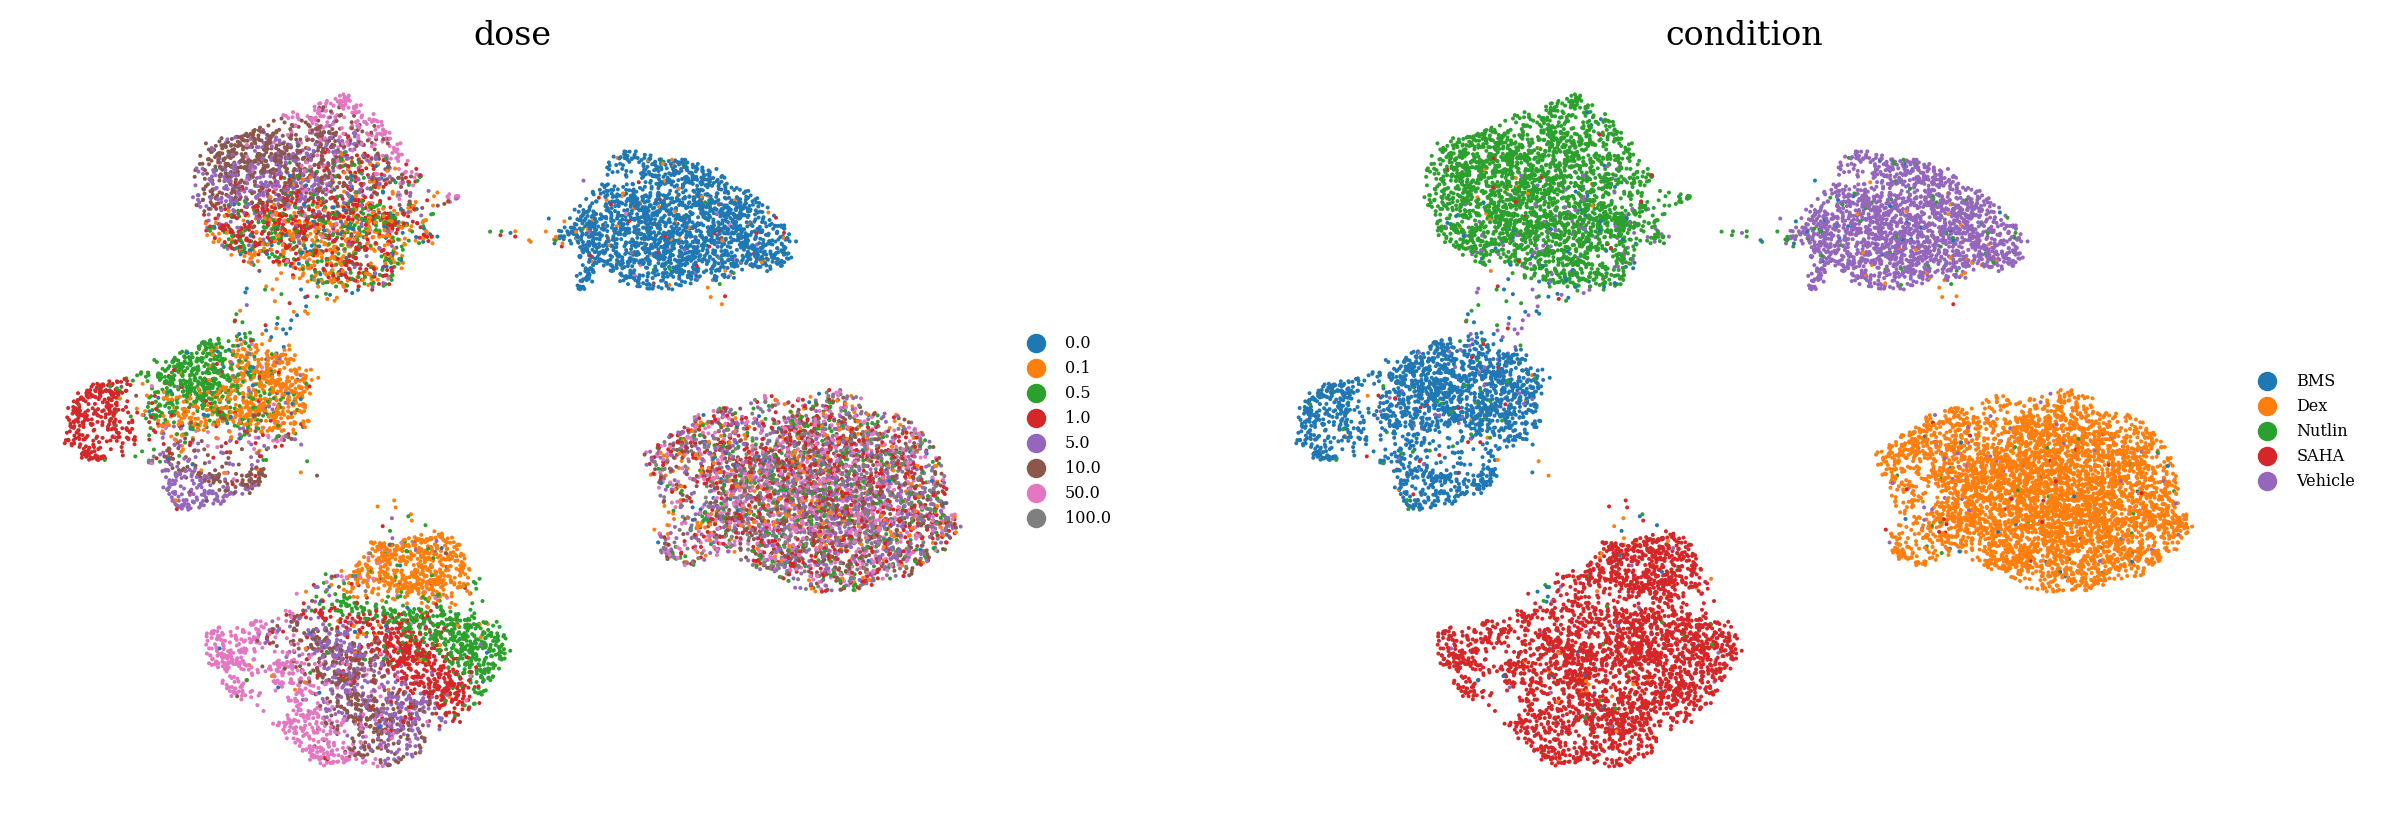

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

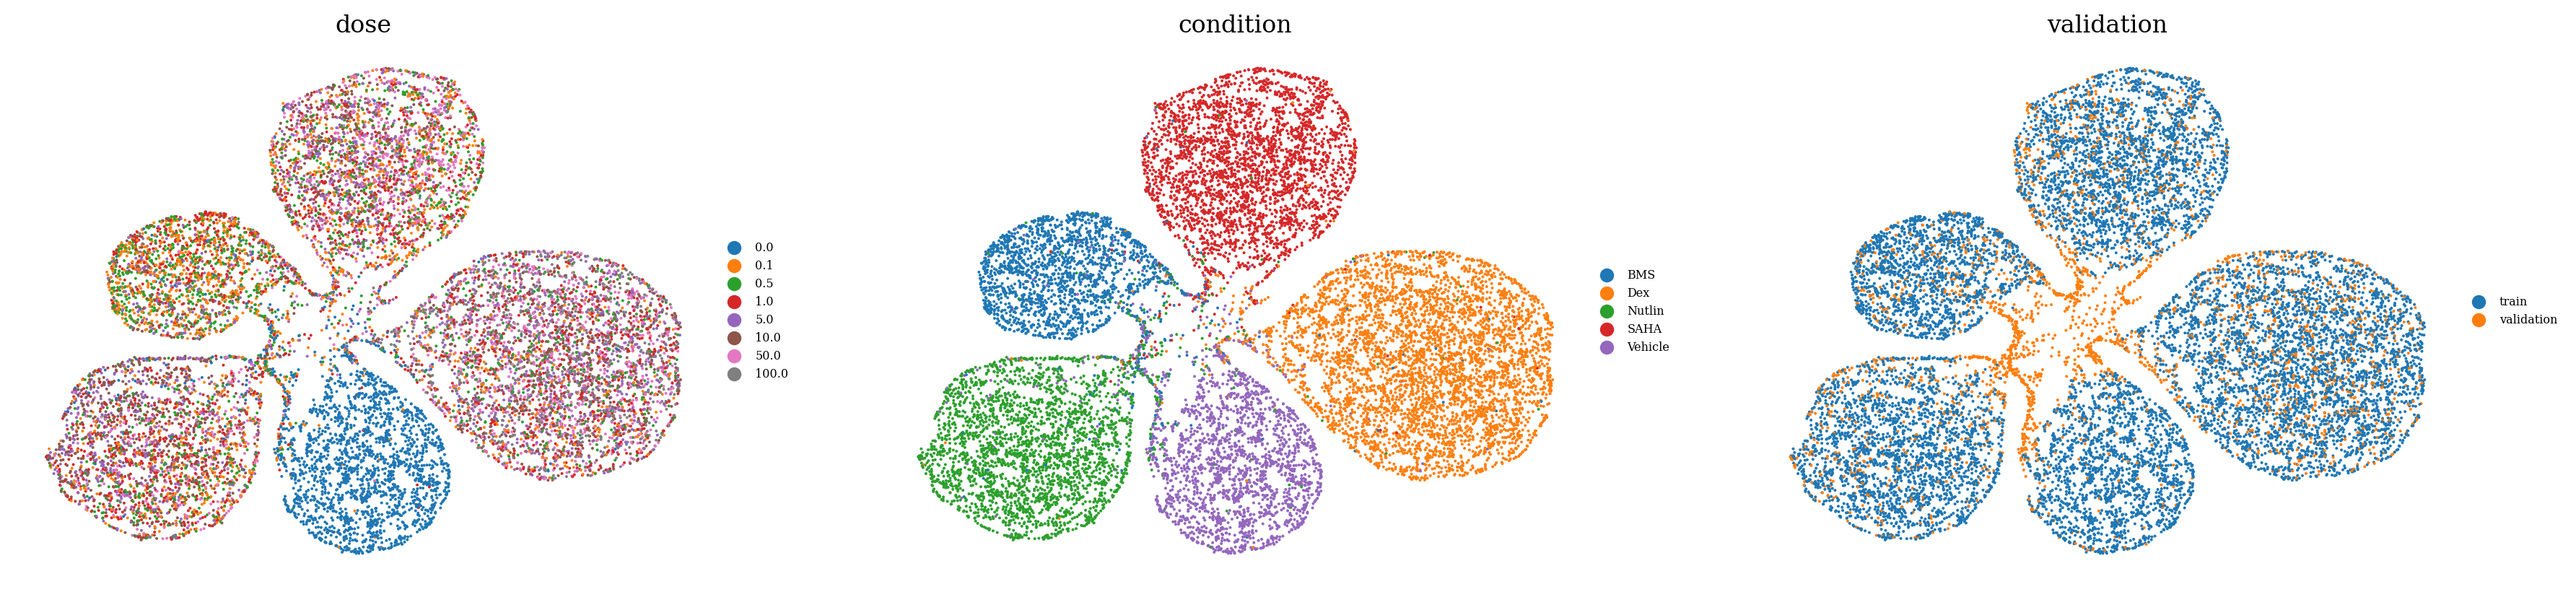

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [27]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


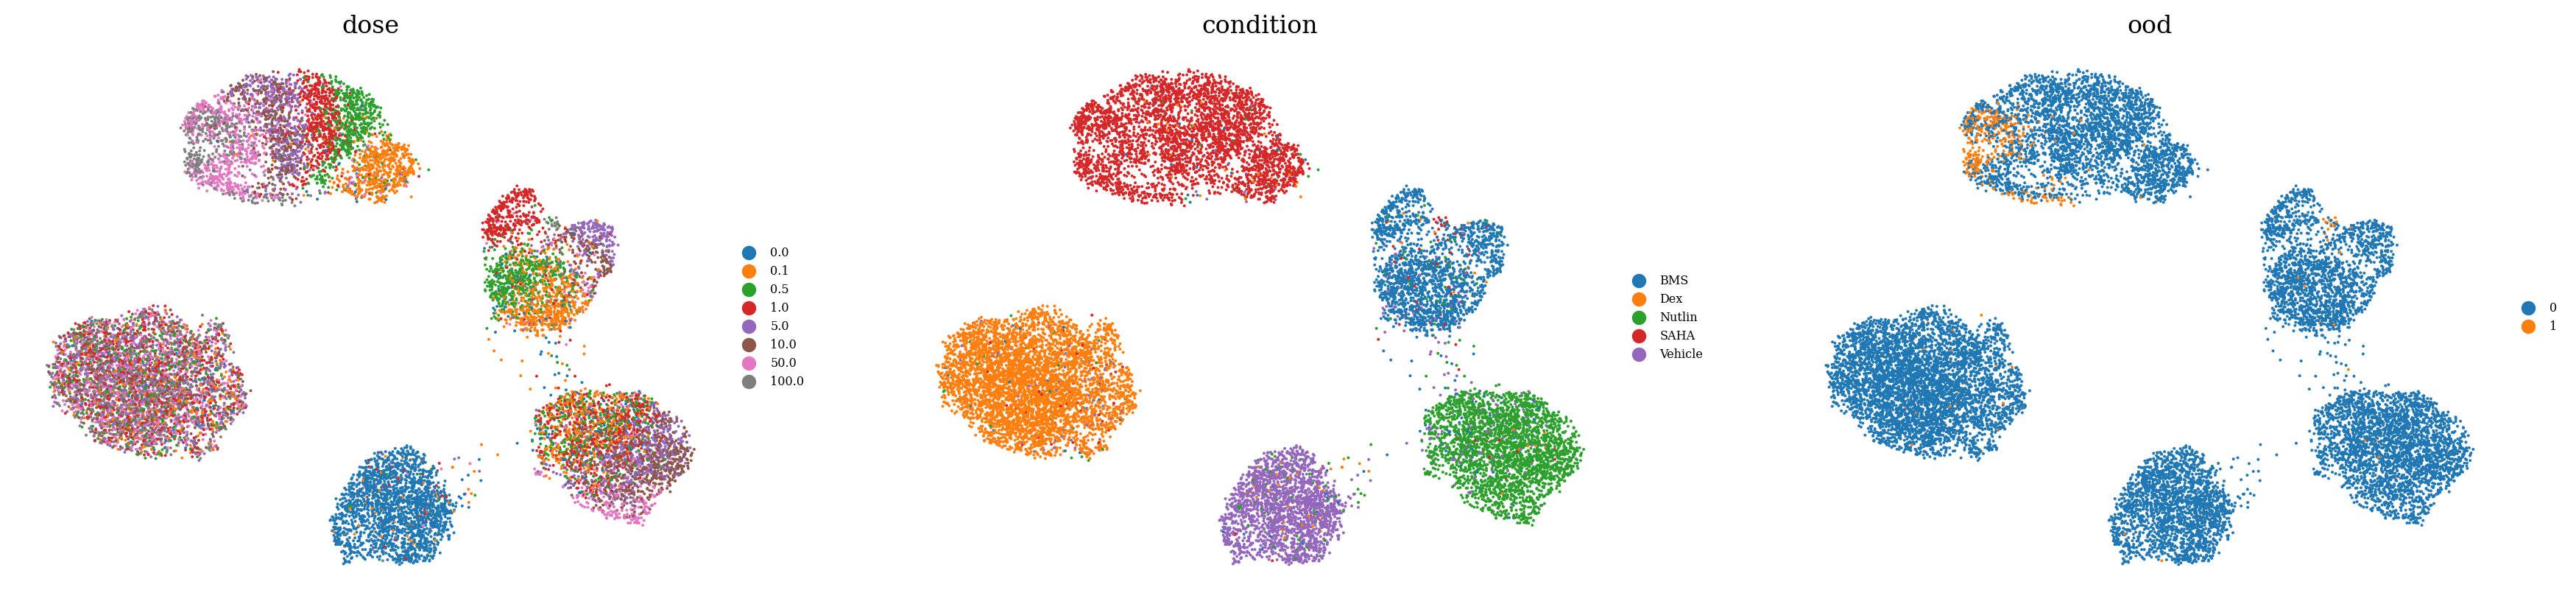

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [29]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


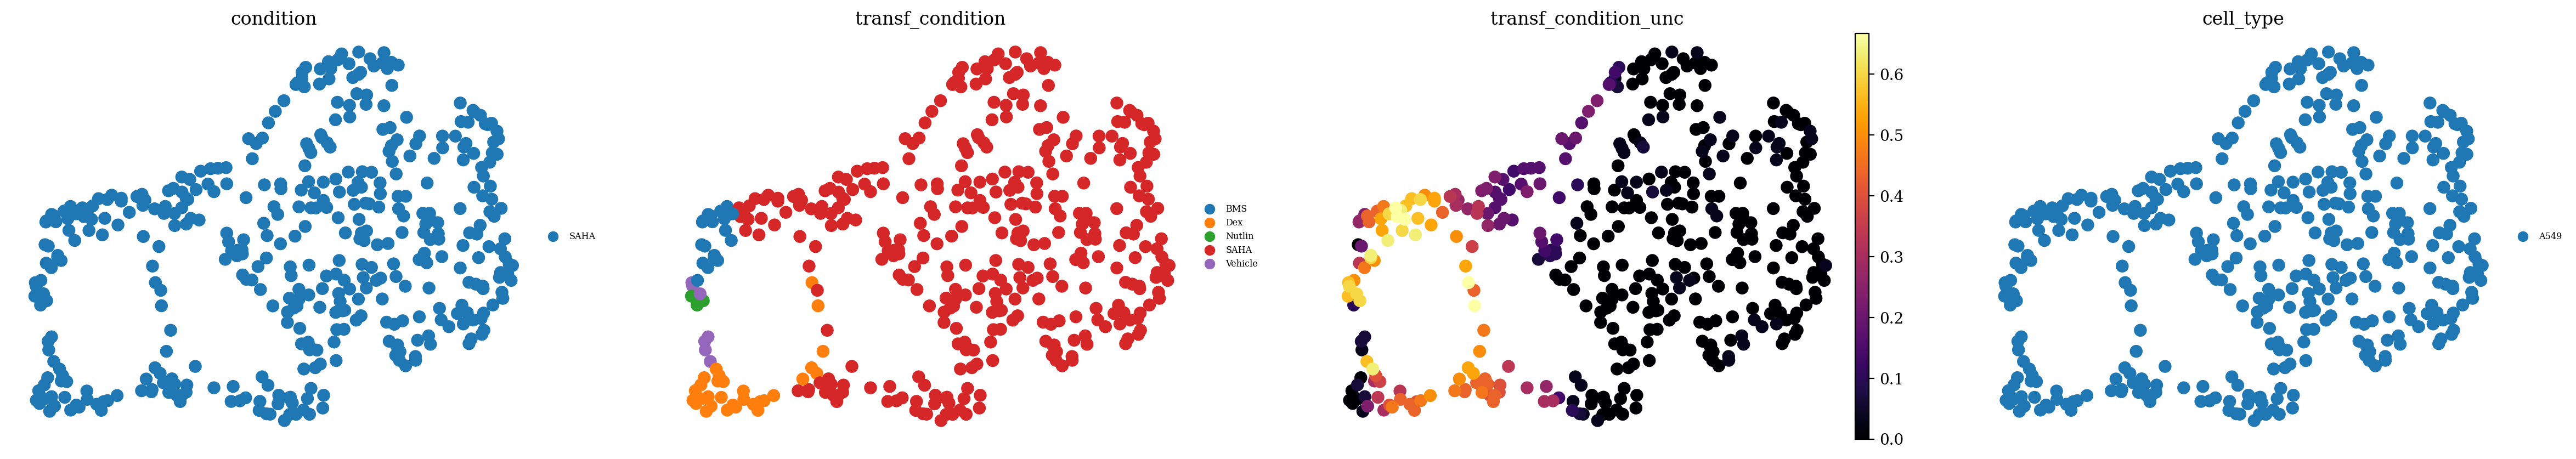

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.8591885441527446,
 'precision_macro': 0.2,
 'recall_macro': 0.1718377088305489,
 'f1_score_macro': 0.18485237483953784,
 'precision_micro': 0.8591885441527446,
 'recall_micro': 0.8591885441527446,
 'f1_score_micro': 0.8591885441527447,
 'precision_weighted': 1.0,
 'recall_weighted': 0.8591885441527446,
 'f1_score_weighted': 0.9242618741976892,
 'confusion_matrix': array([[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [ 19,  30,   3, 360,   7],
        [  0,   0,   0,   0,   0]])}

In [32]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.3016676794274526


In [33]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.21855377759773142
